<font size=6 color='purple'>**Counts plots**</font>

*Notes:* Initialization cells must be run before plotting, since they define colors and snapshot numbers


<font color='red' weight='bold'>**NOTE: cells must be run in order to reproduce the right plot under the right set of data. This is done so that plots can be remade quickly without needing to rerun data**</font>

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gd
from utils.paths import SetupPaths
from utils.get_summary_data import compile_summary
from vectorCorrection import vectorCorrection as vector


paths = SetupPaths()

In [2]:
plt.show();
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in"})


# Initialization

In [3]:
# defining equivalent redshifts
zs = {"z":np.array([0,1,2,3,4]), 
      "zill":np.array([135,85,68,60,56]), 
      "ztng":np.array([99,50,33,25,22])}

In [4]:
# defining color palette for plotting
palette = {"Illustris dark": "#009292", "Illustris hydro": "#B6DAFF",
           "TNG dark": "#930200", "TNG hydro": "#FFB5DC"}


## Function defs

In [5]:
# make functions to get data at the requested snapshot
def get_primmask(primstells, size):
    if size == "dwarf":
        mask = (primstells > 0.01) & (primstells < 0.5)
    elif size == "massive":
        mask = (primstells > 0.5) & (primstells < 10)
    return mask

def get_groupmask(groupmass, size):
    if size == "dwarf":
        mask = (groupmass > 8) & (groupmass < 50)
    elif size == "massive":
        mask = (groupmass > 100) & (groupmass < 650)
    return mask

In [75]:
class EmptyFile(Exception): pass
class SkipRedshift(Exception): pass

def get_paircounts(sim, phys, size, groupCut=False, median=False, errorprint=False, redshiftcutoff=True, **kwargs):    
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts, numAll, numPri, numMaj, numMin = [], [], [], [], []
    fracAll, fracMaj, fracMin = [], [], []
    quartAll, quartPri, quartMaj, quartMin = [], [], [], []
    quartfracAll, quartfracMaj, quartfracMin = [], [], []
       
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_100.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['pairs'][phys]['Group ID']) == 0):    
                raise EmptyFile
                
                
            unpair = pair_data["unpaired"][phys]
            unpairStells = np.array(unpair["Sub1 Stellar Mass"])
            unpairGroups = np.array(unpair["Group Mass"])
            unpairReals = np.array(unpair['Realization'])
            
            pair = pair_data["pairs"][phys]
            priStell = np.array(pair["Sub1 Stellar Mass"])
            secStell = np.array(pair["Sub2 Stellar Mass"])
            pairGroups = np.array(pair["Group Mass"])
            pairGrRads = np.array(pair["Group Radius"])
            pairReals = np.array(pair["Realization"])
            seps = np.array(pair["Separation"]) 
            
            # subset masks for unpaired
            unpair_pri = get_primmask(unpairStells, size)
            unpair_group = get_groupmask(unpairGroups, size)                
            unpair_medreal = unpairReals == -1
            
            pair_pri = get_primmask(priStell, size)
            pair_group = get_groupmask(pairGroups, size)
            pair_medreal = pairReals == -1

            majors = (secStell/priStell > 1/4)
            minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)
            pair_lowsep = (seps > 10) & (seps < 10000)
            pair_rvir = seps < pairGrRads
            # include 1rvir cut 

            # defining combined masks 
            unpair_mask = unpair_pri
            pair_mask = pair_pri
            
            if groupCut:
                unpair_mask = unpair_mask & unpair_group
                pair_mask = pair_mask & pair_group
                
            if median:
                unpair_mask = unpair_mask & unpair_medreal
                pair_mask = pair_mask & pair_medreal
                
                majormask = pair_mask & majors & pair_lowsep & pair_rvir
                minormask = pair_mask & minors & pair_lowsep & pair_rvir
                
                num_unpair = np.count_nonzero(unpair_mask)
                num_pair = np.count_nonzero(pair_mask)   
                num_maj = np.count_nonzero(majormask)   
                num_min = np.count_nonzero(minormask)   
                
                numPri_z = num_pair + num_unpair
                numAll_z = num_pair
                numMaj_z = num_maj
                numMin_z = num_min
                fracAll_z = numAll_z / numPri_z
                fracMaj_z = numMaj_z / numPri_z
                fracMin_z = numMin_z / numPri_z
                quartAll_z, quartPri_z, quartMaj_z, quartMin_z  = [0,0], [0,0], [0,0], [0,0]
                quartfracAll_z, quartfracMaj_z, quartfracMin_z = [0,0], [0,0], [0,0]
                
            elif ~median:
                pri_perreal, all_perreal, maj_perreal, min_perreal = [], [], [], []
                fracall_perreal, fracmaj_perreal, fracmin_perreal = [], [], []
                
                realizations = np.unique( unpairReals )
                
                for real in realizations:                  
                    # make realization masks
                    unpair_real = unpairReals == real
                    pair_real = pairReals == real
                    
                    # make copies of masks
                    unpair_mask_real = unpair_mask & unpair_real
                    pair_mask_real = pair_mask & pair_real
                    
                    majormask_real = pair_mask_real & majors & pair_lowsep & pair_rvir
                    minormask_real = pair_mask_real & minors & pair_lowsep & pair_rvir
                    
                    num_unpair_real = np.count_nonzero(unpair_mask_real)
                    num_pair_real = np.count_nonzero(pair_mask_real)   
                    num_maj_real = np.count_nonzero(majormask_real)   
                    num_min_real = np.count_nonzero(minormask_real)  
                    num_pri_real = num_unpair_real + num_pair_real
                    
                    pri_perreal.append( num_pri_real )
                    all_perreal.append( num_pair_real )
                    maj_perreal.append( num_maj_real )
                    min_perreal.append( num_min_real )
                    fracall_perreal.append( num_pair_real / num_pri_real )
                    fracmaj_perreal.append( num_maj_real / num_pri_real )
                    fracmin_perreal.append( num_min_real / num_pri_real )
                    
                numPri_z = np.median( pri_perreal )
                numAll_z = np.median( all_perreal )
                numMaj_z = np.median( maj_perreal )
                numMin_z = np.median( min_perreal )
                fracAll_z = np.median( fracall_perreal )
                fracMaj_z = np.median( fracmaj_perreal )
                fracMin_z = np.median( fracmin_perreal )
                
                lower, upper = 1, 99
                
                quartPri_z = np.percentile( pri_perreal, [lower,upper])
                quartAll_z = np.percentile( all_perreal, [lower,upper])
                quartMaj_z = np.percentile( maj_perreal, [lower,upper])
                quartMin_z = np.percentile( min_perreal, [lower,upper])
                quartfracAll_z = np.percentile( fracall_perreal, [lower,upper])
                quartfracMaj_z = np.percentile( fracmaj_perreal, [lower,upper])
                quartfracMin_z = np.percentile( fracmin_perreal, [lower,upper])
            
            redshifts.append( redshift )
            numPri.append( numPri_z )
            numAll.append( numAll_z )
            numMaj.append( numMaj_z )
            numMin.append( numMin_z )
            fracAll.append( fracAll_z )
            fracMaj.append( fracMaj_z )
            fracMin.append( fracMin_z )
            quartPri.append( quartPri_z )
            quartAll.append( quartAll_z )
            quartMaj.append( quartMaj_z )
            quartMin.append( quartMin_z )
            quartfracAll.append( quartfracAll_z )
            quartfracMaj.append( quartfracMaj_z )
            quartfracMin.append( quartfracMin_z )
                       
        
        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
    count_dictionary = {
            "z": np.array(redshifts),
            "Number Primaries": np.array(numPri),
            "Number Pairs": np.array(numAll),
            "Number Majors": np.array(numMaj),
            "Number Minors": np.array(numMin),
            "Fraction Pairs": np.array(fracAll),
            "Fraction Majors": np.array(fracMaj),
            "Fraction Minors": np.array(fracMin),
            "Quarts Primaries": np.array(quartPri),
            "Quarts Pairs": np.array(quartAll),
            "Quarts Majors": np.array(quartMaj),
            "Quarts Minors": np.array(quartMin),
            "Quarts Fraction Pairs": np.array(quartfracAll),
            "Quarts Fraction Majors": np.array(quartfracMaj),
            "Quarts Fraction Minors": np.array(quartfracMin)}
    
            
    return count_dictionary

def get_paircounts_simstell(sim, size, groupCut=False, errorprint=False, redshiftcutoff=True, **kwargs):    
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts, numAll, numPri, numMaj, numMin = [], [], [], [], []
    fracAll, fracMaj, fracMin = [], [], []

       
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_simstars.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['paired']["hydro"]['Group ID']) == 0):    
                raise EmptyFile
                
                
            unpair = pair_data["unpaired"]["hydro"]
            unpairStells = np.array(unpair["Sub1 Stellar Mass"])
            unpairGroups = np.array(unpair["Group Mass"])
            unpairReals = np.array(unpair['Realization'])
            
            pair = pair_data["paired"]["hydro"]
            priStell = np.array(pair["Sub1 Stellar Mass"])
            secStell = np.array(pair["Sub2 Stellar Mass"])
            pairGroups = np.array(pair["Group Mass"])
            pairGrRads = np.array(pair["Group Radius"])
            pairReals = np.array(pair["Realization"])
            seps = np.array(pair["Separation"])   
            
            # subset masks for unpaired
            unpair_pri = get_primmask(unpairStells, size)
            unpair_group = get_groupmask(unpairGroups, size)                
            unpair_medreal = unpairReals == -1
            
            pair_pri = get_primmask(priStell, size)
            pair_group = get_groupmask(pairGroups, size)
            pair_medreal = pairReals == -1

            majors = (secStell/priStell > 1/4)
            minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)
            pair_lowsep = (seps > 10) & (seps < 10000)
            pair_rvir = seps < pairGrRads
        
            # defining combined masks 
            unpair_mask = unpair_pri
            pair_mask = pair_pri
            
            if groupCut:
                unpair_mask = unpair_mask & unpair_group
                pair_mask = pair_mask & pair_group
                
            unpair_mask = unpair_mask & unpair_medreal
            pair_mask = pair_mask & pair_medreal
            
            major_mask = pair_mask & majors & pair_lowsep & pair_rvir
            minor_mask = pair_mask & minors & pair_lowsep & pair_rvir
            
            num_unpair = np.count_nonzero(unpair_mask)
            num_pair = np.count_nonzero(pair_mask)   
            num_maj = np.count_nonzero(major_mask)   
            num_min = np.count_nonzero(minor_mask)   

            numPri_z = num_pair + num_unpair
            numAll_z = num_pair
            numMaj_z = num_maj
            numMin_z = num_min
            fracAll_z = numAll_z / numPri_z
            fracMaj_z = numMaj_z / numPri_z
            fracMin_z = numMin_z / numPri_z             
           
            redshifts.append( redshift )
            numPri.append( numPri_z )
            numAll.append( numAll_z )
            numMaj.append( numMaj_z )
            numMin.append( numMin_z )
            fracAll.append( fracAll_z )
            fracMaj.append( fracMaj_z )
            fracMin.append( fracMin_z )
                       
        
        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
    count_dictionary = {
            "z": np.array(redshifts),
            "Number Primaries": np.array(numPri),
            "Number Pairs": np.array(numAll),
            "Number Majors": np.array(numMaj),
            "Number Minors": np.array(numMin),
            "Fraction Pairs": np.array(fracAll),
            "Fraction Majors": np.array(fracMaj),
            "Fraction Minors": np.array(fracMin)
    }
    
            
    return count_dictionary



# Dwarfs

In [76]:
size = "dwarf"
groupCut = True
median = False

illd = get_paircounts("Illustris", "dark", size,groupCut=groupCut, median=median)
illh = get_paircounts("Illustris", "hydro", size,groupCut=groupCut, median=median)
print("done with Illustris")


tngd = get_paircounts("TNG", "dark", size,groupCut=groupCut, median=median)
tngh = get_paircounts("TNG", "hydro", size,groupCut=groupCut, median=median)
print("done with tng")

print("starting stars")
illsim = get_paircounts_simstell("Illustris", size,groupCut=groupCut, median=median)
print("done with ill")
tngsim = get_paircounts_simstell("TNG", size,groupCut=groupCut, median=median)
print("done with tng")



done with Illustris
done with tng
starting stars
done with ill
done with tng


## Counts - Prims, major+minor pairs

"z", "Number Primaries", "Number Pairs", "Number Majors", "Number Minors", "Fraction Pairs", "Fraction Majors", "Fraction Minors", "Quarts Primaries", "Quarts Pairs", "Quarts Majors", "Quarts Minors", "Quarts Fraction Pairs", "Quarts Fraction Majors", "Quarts Fraction Minors"

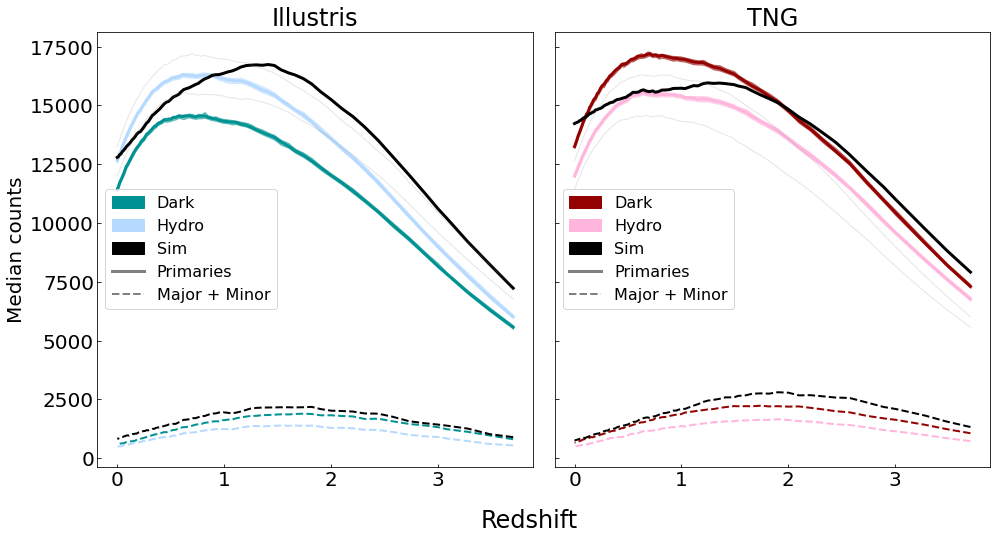

In [77]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1],'wspace': 0.05,"hspace":0.02})

axILL = ax[0]
axTNG = ax[1]
axILL.set(title="Illustris", ylabel="Median counts")
axTNG.set(title="TNG")


########################
# Illustris plot first #
########################
    # fill and color labels
axILL.fill_between(illd['z'], np.array(illd['Quarts Primaries'])[:,0], np.array(illd['Quarts Primaries'])[:,1],color=palette["Illustris dark"],alpha=0.5, label="Dark")
axILL.fill_between(illh['z'], np.array(illh['Quarts Primaries'])[:,0], np.array(illh['Quarts Primaries'])[:,1],color=palette["Illustris hydro"],alpha=0.5, label="Hydro")
axILL.fill_between(illh['z'], np.array(illh['Quarts Primaries'])[:,0], np.array(illh['Quarts Primaries'])[:,1],color='black',alpha=0, label="Sim")

    # lines
axILL.plot(illd['z'],illd['Number Primaries'], color=palette["Illustris dark"], lw=3)
axILL.plot(illh['z'],illh['Number Primaries'], color=palette["Illustris hydro"], lw=3)
axILL.plot(illsim['z'],illsim['Number Primaries'], color='black', lw=3)
axILL.plot(illd['z'],illd['Number Majors']+illd['Number Minors'], color=palette["Illustris dark"], lw=2, linestyle="dashed")
axILL.plot(illh['z'],illh['Number Majors']+illh['Number Minors'], color=palette["Illustris hydro"], lw=2, linestyle="dashed")
axILL.plot(illsim['z'],illsim['Number Majors']+illsim['Number Minors'], color='black', lw=2,linestyle="dashed")

    # tng comparison
axILL.plot(tngd['z'],tngd['Number Primaries'], color='grey',alpha=0.2, lw=1)
axILL.plot(tngh['z'],tngh['Number Primaries'], color='grey',alpha=0.2, lw=1)

    # for labeling plots
axILL.plot(illh['z'][0],illh['Number Primaries'][0], color='grey', lw=3, label="Primaries")
axILL.plot(illh['z'][0],illh['Number Majors'][0]+illh['Number Minors'][0], color='grey', lw=2, linestyle="dashed",label='Major + Minor')

############
# TNG plot #
############
    # fill and color labels
axTNG.fill_between(tngd['z'], np.array(tngd['Quarts Primaries'])[:,0], np.array(tngd['Quarts Primaries'])[:,1],color=palette["TNG dark"],alpha=0.5, label="Dark")
axTNG.fill_between(tngh['z'], np.array(tngh['Quarts Primaries'])[:,0], np.array(tngh['Quarts Primaries'])[:,1],color=palette["TNG hydro"],alpha=0.5, label="Hydro")
axTNG.fill_between(tngh['z'], np.array(tngh['Quarts Primaries'])[:,0], np.array(tngh['Quarts Primaries'])[:,1],color='black',alpha=0, label="Sim")

    # lines
axTNG.plot(tngd['z'],tngd['Number Primaries'], color=palette["TNG dark"], lw=3)
axTNG.plot(tngh['z'],tngh['Number Primaries'], color=palette["TNG hydro"], lw=3)
axTNG.plot(tngsim['z'],tngsim['Number Primaries'], color='black', lw=3)
axTNG.plot(tngd['z'],tngd['Number Majors']+tngd['Number Minors'], color=palette["TNG dark"], lw=2, linestyle="dashed")
axTNG.plot(tngh['z'],tngh['Number Majors']+tngh['Number Minors'], color=palette["TNG hydro"], lw=2, linestyle="dashed")
axTNG.plot(tngh['z'],tngsim['Number Majors']+tngsim['Number Minors'], color='black', lw=2, linestyle="dashed")

    # tng comparison
axTNG.plot(illd['z'],illd['Number Primaries'], color='grey',alpha=0.2, lw=1)
axTNG.plot(illh['z'],illh['Number Primaries'], color='grey',alpha=0.2, lw=1)

    # for labeling plots
axTNG.plot(tngh['z'][0],tngh['Number Primaries'][0], color='grey', lw=3,label='Primaries')
axTNG.plot(tngh['z'][0],tngh['Number Majors'][0]+tngh['Number Minors'][0], color='grey', lw=2, linestyle="dashed",label='Major + Minor')


################
# Plot styling #
################
axILL.legend(loc="upper right",fontsize=16)
axTNG.legend(loc="upper right",fontsize=16)

for ax in ax:
    leg = ax.legend(fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        
fig.supxlabel("Redshift")
plt.savefig(f"../plots/counts/pri_majmin_rvir_d.png",bbox_inches='tight',facecolor="white")
plt.show()


## Pair fracs

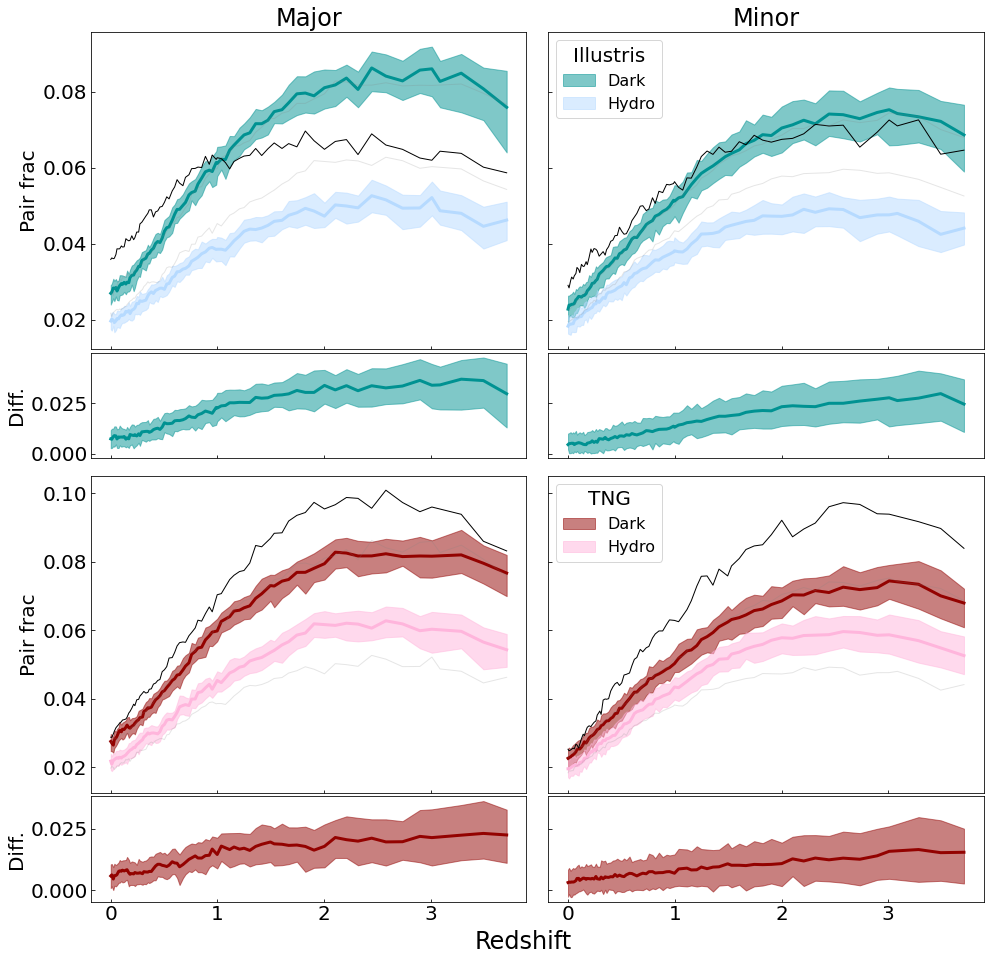

In [79]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.1,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]

axtngmaj = ax[3][0]
axtngmin = ax[3][1]

axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

al = 0.5

###################
# Illustris major #
###################
axillmaj.set(title="Major", ylabel="Pair frac")
axillmaj.plot(illd['z'],illd['Fraction Majors'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Fraction Majors'], color=palette["Illustris hydro"], lw=3)
axillmaj.plot(illsim['z'],illsim['Fraction Majors'], color='black', lw=1)

axillmaj.fill_between(illd['z'], np.array(illd['Quarts Fraction Majors'])[:,0], np.array(illd['Quarts Fraction Majors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Quarts Fraction Majors'])[:,0]-np.array(illd['Quarts Fraction Majors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Majors'])[:,1]-np.array(illd['Quarts Fraction Majors'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illd['Fraction Majors'])-np.array(illh['Fraction Majors']) ), color=palette["Illustris dark"], lw=3)
axillmajdiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.set(title="Minor")
axillmin.plot(illd['z'],illd['Fraction Minors'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Fraction Minors'], color=palette["Illustris hydro"], lw=3)
axillmin.plot(illsim['z'],illsim['Fraction Minors'], color='black', lw=1)

axillmin.fill_between(illd['z'], np.array(illd['Quarts Fraction Minors'])[:,0], np.array(illd['Quarts Fraction Minors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Quarts Fraction Minors'])[:,0]-np.array(illd['Quarts Fraction Minors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Minors'])[:,1]-np.array(illd['Quarts Fraction Minors'])[:,0]

axillmindiff.plot(illd['z'], (np.array(illd['Fraction Minors'])-np.array(illh['Fraction Minors']) ), color=palette["Illustris dark"], lw=3)
axillmindiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


#############
# TNG major #
#############
axtngmaj.set(ylabel="Pair frac")
axtngmaj.plot(tngd['z'],tngd['Fraction Majors'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Fraction Majors'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color='black', lw=1)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Majors'])[:,0], np.array(tngd['Quarts Fraction Majors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Majors'])[:,0], np.array(tngh['Quarts Fraction Majors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngd['Quarts Fraction Majors'])[:,0]-np.array(tngh['Quarts Fraction Majors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Majors'])[:,1]-np.array(tngh['Quarts Fraction Majors'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngd['Fraction Majors'])-np.array(tngh['Fraction Majors']) ), color=palette["TNG dark"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Fraction Minors'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Fraction Minors'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color='black', lw=1)

axtngmin.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Minors'])[:,0], np.array(tngd['Quarts Fraction Minors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngd['Quarts Fraction Minors'])[:,0]-np.array(tngh['Quarts Fraction Minors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Minors'])[:,1]-np.array(tngh['Quarts Fraction Minors'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngd['Fraction Minors'])-np.array(tngh['Fraction Minors']) ), color=palette["TNG dark"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper left",fontsize=16)
axtngmin.legend(title="TNG",loc="upper left",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/counts/pairfrac_majorminor_d_100Rvir.png",bbox_inches='tight',facecolor="white")
plt.show()


# Massive

In [80]:
size = "massive"
groupCut = True
median = False

illd = get_paircounts("Illustris", "dark", size,groupCut=groupCut, median=median)
illh = get_paircounts("Illustris", "hydro", size,groupCut=groupCut, median=median)
print("done with Illustris")


tngd = get_paircounts("TNG", "dark", size,groupCut=groupCut, median=median)
tngh = get_paircounts("TNG", "hydro", size,groupCut=groupCut, median=median)
print("done with tng")

print("starting stars")
illsim = get_paircounts_simstell("Illustris", size,groupCut=groupCut, median=median)
print("done with ill")
tngsim = get_paircounts_simstell("TNG", size,groupCut=groupCut, median=median)
print("done with tng")



done with Illustris
done with tng
starting stars
done with ill
done with tng


## Counts - prims, major+minor pairs

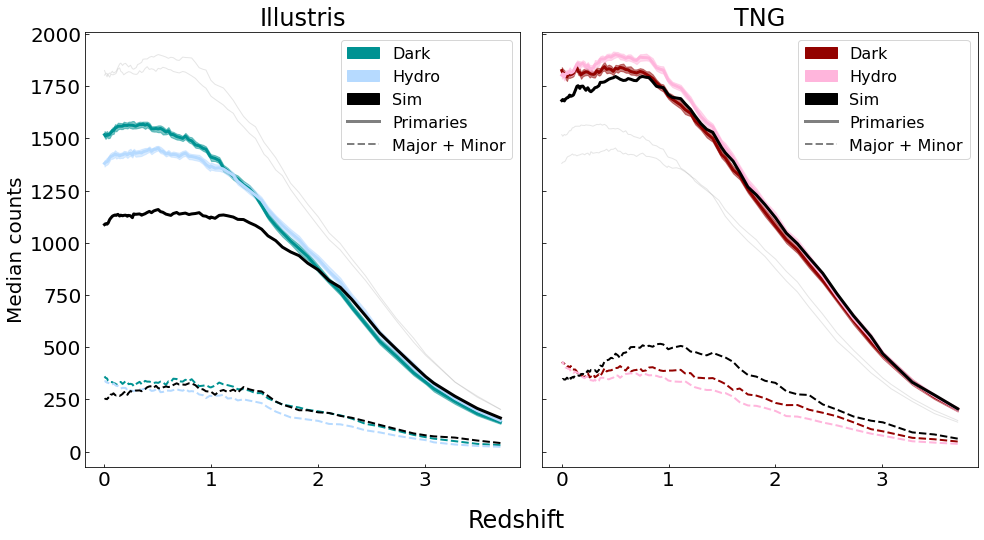

In [81]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(1, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[1],'wspace': 0.05,"hspace":0.02})

axILL = ax[0]
axTNG = ax[1]
# axilldiff = ax[1][0]
# axtngdiff = ax[1][1]

########################
# Illustris plot first #
########################
axILL.set(title="Illustris", ylabel="Median counts")

    # fill and color labels
axILL.fill_between(illd['z'], np.array(illd['Quarts Primaries'])[:,0], np.array(illd['Quarts Primaries'])[:,1],color=palette["Illustris dark"],alpha=0.5, label="Dark")
axILL.fill_between(illh['z'], np.array(illh['Quarts Primaries'])[:,0], np.array(illh['Quarts Primaries'])[:,1],color=palette["Illustris hydro"],alpha=0.5, label="Hydro")
axILL.fill_between(illh['z'], np.array(illh['Quarts Primaries'])[:,0], np.array(illh['Quarts Primaries'])[:,1],color='black',alpha=0, label="Sim")

    # lines
axILL.plot(illd['z'],illd['Number Primaries'], color=palette["Illustris dark"], lw=3)
axILL.plot(illh['z'],illh['Number Primaries'], color=palette["Illustris hydro"], lw=3)
axILL.plot(illsim['z'],illsim['Number Primaries'], color='black', lw=3)
axILL.plot(illd['z'],illd['Number Majors']+illd['Number Minors'], color=palette["Illustris dark"], lw=2, linestyle="dashed")
axILL.plot(illh['z'],illh['Number Majors']+illh['Number Minors'], color=palette["Illustris hydro"], lw=2, linestyle="dashed")
axILL.plot(illsim['z'],illsim['Number Majors']+illsim['Number Minors'], color='black', lw=2,linestyle="dashed")

    # tng comparison
axILL.plot(tngd['z'],tngd['Number Primaries'], color='grey',alpha=0.2, lw=1)
axILL.plot(tngh['z'],tngh['Number Primaries'], color='grey',alpha=0.2, lw=1)

    # for labeling plots
axILL.plot(illh['z'][0],illh['Number Primaries'][0], color='grey', lw=3, label="Primaries")
axILL.plot(illh['z'][0],illh['Number Majors'][0]+illh['Number Minors'][0], color='grey', lw=2, linestyle="dashed",label='Major + Minor')


# ############
# # TNG plot #
# ############
axTNG.set(title="TNG")

    # fill and color labels
axTNG.fill_between(tngd['z'], np.array(tngd['Quarts Primaries'])[:,0], np.array(tngd['Quarts Primaries'])[:,1],color=palette["TNG dark"],alpha=0.5, label="Dark")
axTNG.fill_between(tngh['z'], np.array(tngh['Quarts Primaries'])[:,0], np.array(tngh['Quarts Primaries'])[:,1],color=palette["TNG hydro"],alpha=0.5, label="Hydro")
axTNG.fill_between(tngh['z'], np.array(tngh['Quarts Primaries'])[:,0], np.array(tngh['Quarts Primaries'])[:,1],color='black',alpha=0, label="Sim")

    # lines
axTNG.plot(tngd['z'],tngd['Number Primaries'], color=palette["TNG dark"], lw=3)
axTNG.plot(tngh['z'],tngh['Number Primaries'], color=palette["TNG hydro"], lw=3)
axTNG.plot(tngsim['z'],tngsim['Number Primaries'], color='black', lw=3)
axTNG.plot(tngd['z'],tngd['Number Majors']+tngd['Number Minors'], color=palette["TNG dark"], lw=2, linestyle="dashed")
axTNG.plot(tngh['z'],tngh['Number Majors']+tngh['Number Minors'], color=palette["TNG hydro"], lw=2, linestyle="dashed")
axTNG.plot(tngh['z'],tngsim['Number Majors']+tngsim['Number Minors'], color='black', lw=2, linestyle="dashed")

    # tng comparison
axTNG.plot(illd['z'],illd['Number Primaries'], color='grey',alpha=0.2, lw=1)
axTNG.plot(illh['z'],illh['Number Primaries'], color='grey',alpha=0.2, lw=1)

    # for labeling plots
axTNG.plot(tngh['z'][0],tngh['Number Primaries'][0], color='grey', lw=3,label='Primaries')
axTNG.plot(tngh['z'][0],tngh['Number Majors'][0]+tngh['Number Minors'][0], color='grey', lw=2, linestyle="dashed",label='Major + Minor')

# ################
# # Plot styling #
# ################
axILL.legend(loc="upper right",fontsize=16)
axTNG.legend(loc="upper right",fontsize=16)

for ax in ax:
    leg = ax.legend(fontsize=16)

    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        
fig.supxlabel("Redshift")
plt.savefig(f"../plots/counts/pri_majmin_rvir_m.png",bbox_inches='tight',facecolor="white")
plt.show()


## Pair fracs

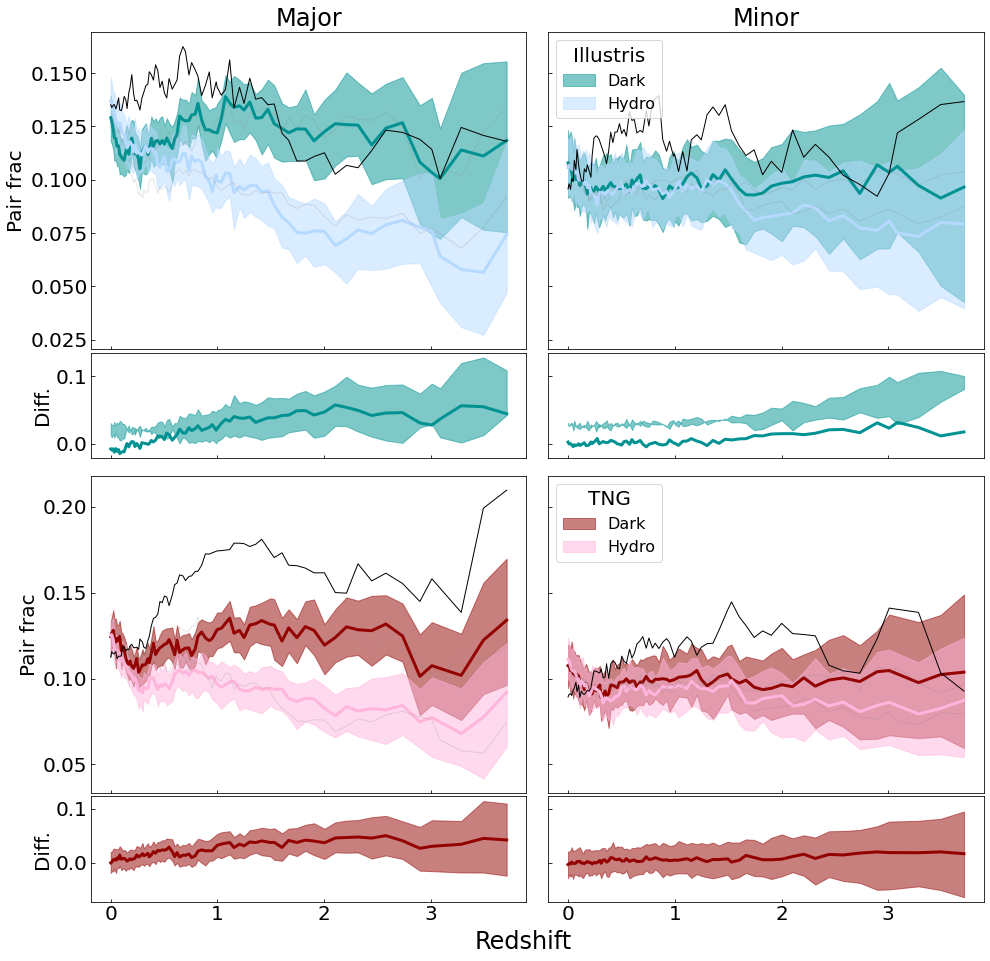

In [82]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.1,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]

axtngmaj = ax[3][0]
axtngmin = ax[3][1]

axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

al = 0.5

###################
# Illustris major #
###################
axillmaj.set(title="Major", ylabel="Pair frac")
axillmaj.plot(illd['z'],illd['Fraction Majors'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Fraction Majors'], color=palette["Illustris hydro"], lw=3)
axillmaj.plot(illsim['z'],illsim['Fraction Majors'], color='black', lw=1)

axillmaj.fill_between(illd['z'], np.array(illd['Quarts Fraction Majors'])[:,0], np.array(illd['Quarts Fraction Majors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Quarts Fraction Majors'])[:,0]-np.array(illd['Quarts Fraction Majors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Majors'])[:,1]-np.array(illd['Quarts Fraction Majors'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illd['Fraction Majors'])-np.array(illh['Fraction Majors']) ), color=palette["Illustris dark"], lw=3)
axillmajdiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.set(title="Minor")
axillmin.plot(illd['z'],illd['Fraction Minors'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Fraction Minors'], color=palette["Illustris hydro"], lw=3)
axillmin.plot(illsim['z'],illsim['Fraction Minors'], color='black', lw=1)

axillmin.fill_between(illd['z'], np.array(illd['Quarts Fraction Minors'])[:,0], np.array(illd['Quarts Fraction Minors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Quarts Fraction Minors'])[:,0]-np.array(illd['Quarts Fraction Minors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Minors'])[:,1]-np.array(illd['Quarts Fraction Minors'])[:,0]

axillmindiff.plot(illd['z'], (np.array(illd['Fraction Minors'])-np.array(illh['Fraction Minors']) ), color=palette["Illustris dark"], lw=3)
axillmindiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


#############
# TNG major #
#############
axtngmaj.set(ylabel="Pair frac")
axtngmaj.plot(tngd['z'],tngd['Fraction Majors'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Fraction Majors'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color='black', lw=1)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Majors'])[:,0], np.array(tngd['Quarts Fraction Majors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Majors'])[:,0], np.array(tngh['Quarts Fraction Majors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngd['Quarts Fraction Majors'])[:,0]-np.array(tngh['Quarts Fraction Majors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Majors'])[:,1]-np.array(tngh['Quarts Fraction Majors'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngd['Fraction Majors'])-np.array(tngh['Fraction Majors']) ), color=palette["TNG dark"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Fraction Minors'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Fraction Minors'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color='black', lw=1)

axtngmin.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Minors'])[:,0], np.array(tngd['Quarts Fraction Minors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngd['Quarts Fraction Minors'])[:,0]-np.array(tngh['Quarts Fraction Minors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Minors'])[:,1]-np.array(tngh['Quarts Fraction Minors'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngd['Fraction Minors'])-np.array(tngh['Fraction Minors']) ), color=palette["TNG dark"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper left",fontsize=16)
axtngmin.legend(title="TNG",loc="upper left",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/counts/pairfrac_majorminor_m_100Rvir.png",bbox_inches='tight',facecolor="white")
plt.show()


# Counts - Prims, Paired, Unpaired

In [ ]:
need to use different redshift cuts cause 54 dne, and 53+55 hydro dne

# function to get the halo counts 
def get_counts(sim, phys, size, groupCut=False, median=False, errorprint=False, redshiftcutoff=True):    
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts, medians, quarts, unpairs, pairs = [], [], [], [], []
       
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_10.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['pairs'][phys]['Group ID']) == 0):    
                raise EmptyFile
                
                
            unpaired = pair_data["unpaired"][phys]
            unpaired_stells = np.array(unpaired["Sub1 Stellar Mass"])
            unpaired_prims = get_primmask(unpaired_stells, size)
            unpaired_group = get_groupmask(np.array(unpaired["Group Mass"]), size)                
            unpaired_median = np.array( unpaired['Realization'] )==-1
            
            paired = pair_data["pairs"][phys]
            paired_stells = np.array(paired["Sub1 Stellar Mass"])
            paired_prims = get_primmask(paired_stells, size)
            paired_group = get_groupmask(np.array(paired["Group Mass"]), size)
            paired_median = np.array( paired['Realization'] )==-1

                
            if median:
                if groupCut:
                    unpaired_mask = unpaired_prims & unpaired_group & unpaired_median
                    paired_mask = paired_prims & paired_group & paired_median
                
                else: 
                    unpaired_mask = unpaired_prims & unpaired_median
                    paired_mask = paired_prims & paired_median
                
                num_unpaired = np.count_nonzero(unpaired_mask)
                num_paired = np.count_nonzero(paired_mask)
                num_prims = num_unpaired + num_paired             
                quarts_z = [0,0]

                
            else: 
                unpaired_per_real = []
                paired_per_real = []
                total_per_real = []
                
                realizations = np.unique( np.array(paired['Realization']) )
                
                for real in realizations:
                    unpaired_real = np.array( unpaired['Realization'] ) == real
                    paired_real = np.array( paired['Realization'] ) == real
                    
                    if groupCut:
                        unpaired_mask = unpaired_prims & unpaired_group & unpaired_real
                        paired_mask = paired_prims & paired_group & paired_real
                        
                    else:
                        unpaired_mask = unpaired_prims & unpaired_real
                        paired_mask = paired_prims & paired_real
                        
                    unpaired_per_real.append( np.count_nonzero(unpaired_mask) )
                    paired_per_real.append( np.count_nonzero(paired_mask) )
                    total_per_real.append( np.count_nonzero(unpaired_mask)+np.count_nonzero(paired_mask) )
                    
                num_unpaired = np.median(unpaired_per_real)
                num_paired = np.median(paired_per_real)
                num_prims = np.median(total_per_real)
                quarts_z = np.percentile( total_per_real,[16,84] ) 
                
            redshifts.append(redshift)
            unpairs.append( num_unpaired )
            pairs.append( num_paired )
            medians.append( num_prims )
            quarts.append( quarts_z )
                       
        
        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
    count_dictionary = {"z":np.array(redshifts),
                        "medians": np.array(medians),
                        "quartiles": np.array(quarts),
                        "unpaired": np.array(unpairs),
                        "paired": np.array(pairs)}
    
    return count_dictionary
        
def get_counts_simstell(sim, size, groupCut=False, errorprint=False, redshiftcutoff=True):
    if sim == "Illustris":
        snapshots = np.arange(0,136,1)
        snapshots = np.delete(snapshots, np.where(snapshots==113)[0])
        redcutoff = 3.8
    elif sim == "TNG":
        snapshots = np.arange(0,100,1)
        snapshots = np.delete(snapshots, np.where(snapshots==48)[0])
        redcutoff = 4
        
    redshifts, medians, quarts, unpairs, pairs = [], [], [], [], []  
    
    for snap in snapshots:  
        try:
            pair_path = f"{sim}_{snap}_simstars.hdf5"
            pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")
            
            if np.size(pair_data) == 0:
                raise EmptyFile
                
            redshift = pair_data['Header'].attrs['Redshift']
            
            if redshiftcutoff & ( redshift > redcutoff) :
                raise SkipRedshift
                
            if (len(pair_data['paired']["hydro"]['Group ID']) == 0):    
                raise EmptyFile
                
                
            unpaired = pair_data["unpaired"]["hydro"]
            unpaired_stells = np.array(unpaired["Sub1 Stellar Mass"])
            unpaired_prims = get_primmask(unpaired_stells, size)
            unpaired_group = get_groupmask(np.array(unpaired["Group Mass"]), size)                
            
            paired = pair_data["paired"]["hydro"]
            paired_stells = np.array(paired["Sub1 Stellar Mass"])
            paired_prims = get_primmask(paired_stells, size)
            paired_group = get_groupmask(np.array(paired["Group Mass"]), size)
                
            if groupCut:
                unpaired_mask = unpaired_prims & unpaired_group 
                paired_mask = paired_prims & paired_group 

            else: 
                unpaired_mask = unpaired_prims 
                paired_mask = paired_prims

            num_unpaired = np.count_nonzero(unpaired_mask)
            num_paired = np.count_nonzero(paired_mask)
            num_prims = num_unpaired + num_paired             
            quarts_z = [0,0]
                
            redshifts.append(redshift)
            unpairs.append( num_unpaired )
            pairs.append( num_paired )
            medians.append( num_prims )
            quarts.append( quarts_z )
                       
        
        except KeyError:
            if errorprint: print(f'skipping {snap} for KeyError. Please debug')
            continue
            
        except EmptyFile:
            if errorprint: print(f"skipping {snap}, empty file")
            continue
            
        except SkipRedshift:
            if errorprint: print(f"skipping {snap}, redshift out of range")
                
    count_dictionary = {"z":np.array(redshifts),
                        "medians": np.array(medians),
                        "quartiles": np.array(quarts),
                        "unpaired": np.array(unpairs),
                        "paired": np.array(pairs)}
    
    return count_dictionary
        
    

get_counts(sim, phys, size, groupCut=False, median=False, errorprint=False, redshiftcutoff=True)

get_counts_simstell(sim, size, groupCut=False, errorprint=False, redshiftcutoff=True)

## Dwarfs

In [20]:
illd = get_counts("Illustris", "dark", "dwarf")
illh = get_counts("Illustris", "hydro", "dwarf")
print("done with Illustris")


tngd = get_counts("TNG", "dark", "dwarf")
tngh = get_counts("TNG", "hydro", "dwarf")
print("done with tng")

print("starting stars")
illsim = get_counts_simstell("Illustris", "dwarf")
print("done with ill")
tngsim = get_counts_simstell("TNG", "dwarf")
print("done with tng")


done with Illustris
done with tng
starting stars
done with ill
done with tng


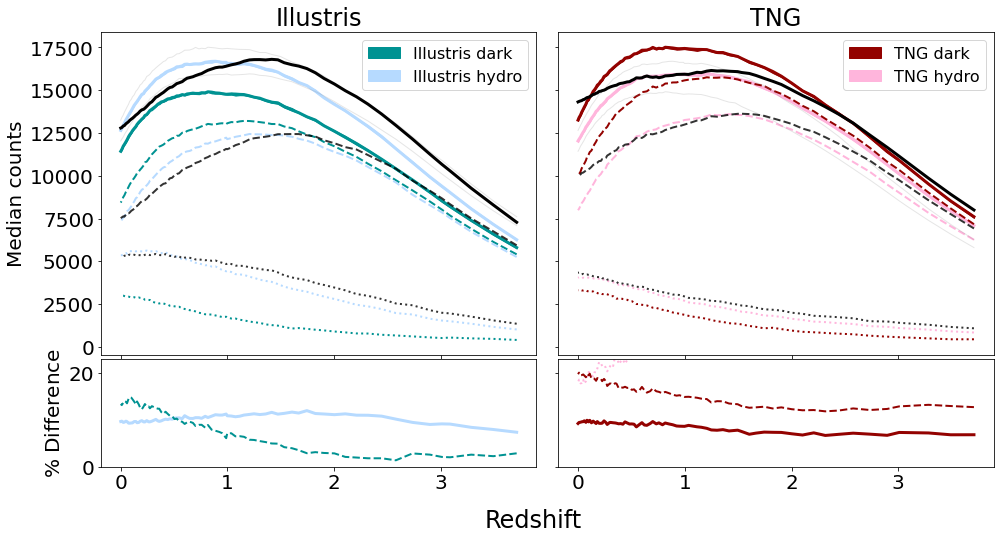

In [21]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1],'wspace': 0.05,"hspace":0.02})

axILL = ax[0][0]
axTNG = ax[0][1]
axilldiff = ax[1][0]
axtngdiff = ax[1][1]

# illd, illh = Illustris['dark'], Illustris['hydro']
# tngd, tngh = TNG['dark'], TNG['hydro']

########################
# Illustris plot first #
########################
axILL.set(title="Illustris", ylabel="Median counts")

axILL.plot(illd['z'],illd['medians'], color=palette["Illustris dark"], lw=3)
axILL.plot(illh['z'],illh['medians'], color=palette["Illustris hydro"], lw=3)

axILL.plot(illd['z'],illd['unpaired'], color=palette["Illustris dark"], lw=2, linestyle="dotted")
axILL.plot(illh['z'],illh['unpaired'], color=palette["Illustris hydro"], lw=2, linestyle="dotted")
axILL.plot(illd['z'],illd['paired'], color=palette["Illustris dark"], lw=2, linestyle="dashed")
axILL.plot(illh['z'],illh['paired'], color=palette["Illustris hydro"], lw=2, linestyle="dashed")

axILL.fill_between(illd['z'], np.array(illd['quartiles'])[:,0], np.array(illd['quartiles'])[:,1],color=palette["Illustris dark"],alpha=1, label="Illustris dark")
axILL.fill_between(illh['z'], np.array(illh['quartiles'])[:,0], np.array(illh['quartiles'])[:,1],color=palette["Illustris hydro"],alpha=1, label="Illustris hydro")

axILL.plot(tngd['z'],tngd['medians'], color='grey',alpha=0.2, lw=1)
axILL.plot(tngh['z'],tngh['medians'], color='grey',alpha=0.2, lw=1)

axILL.plot(illsim['z'],illsim['medians'], color='black', lw=3)
axILL.plot(illsim['z'],illsim['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
axILL.plot(illsim['z'],illsim['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


############
# TNG plot #
############
axTNG.set(title="TNG")
axTNG.plot(tngd['z'],tngd['medians'], color=palette["TNG dark"], lw=3)
axTNG.plot(tngh['z'],tngh['medians'], color=palette["TNG hydro"], lw=3)

axTNG.plot(tngd['z'],tngd['unpaired'], color=palette["TNG dark"], lw=2, linestyle="dotted")
axTNG.plot(tngh['z'],tngh['unpaired'], color=palette["TNG hydro"], lw=2, linestyle="dotted")
axTNG.plot(tngd['z'],tngd['paired'], color=palette["TNG dark"], lw=2, linestyle="dashed")
axTNG.plot(tngh['z'],tngh['paired'], color=palette["TNG hydro"], lw=2, linestyle="dashed")

axTNG.fill_between(tngd['z'], np.array(tngd['quartiles'])[:,0], np.array(tngd['quartiles'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
axTNG.fill_between(tngh['z'], np.array(tngh['quartiles'])[:,0], np.array(tngh['quartiles'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

axTNG.plot(illd['z'],illd['medians'], color='grey',alpha=0.2, lw=1)
axTNG.plot(illh['z'],illh['medians'], color='grey',alpha=0.2, lw=1)

axTNG.plot(tngsim['z'],tngsim['medians'], color='black', lw=3)
axTNG.plot(tngsim['z'],tngsim['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
axTNG.plot(tngsim['z'],tngsim['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


########################
# Illustris difference #
########################
axilldiff.set(ylabel=r"$\%$ Difference")
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['medians'])-np.array(illh['medians']) )/np.array(illh['medians']), color=palette["Illustris hydro"], lw=3)
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) )/np.array(illh['unpaired']), color=palette["Illustris hydro"], lw=2, linestyle='dotted')
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['paired'])-np.array(illh['paired']) )/np.array(illd['paired']), color=palette["Illustris dark"], lw=2, linestyle='dashed')


########################
# Illustris difference #
########################
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['medians'])-np.array(tngh['medians']) )/np.array(tngd['medians']), color=palette["TNG dark"], lw=3)
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) )/np.array(tngh['unpaired']), color=palette["TNG hydro"], lw=2, linestyle='dotted')
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) )/np.array(tngd['paired']), color=palette["TNG dark"], lw=2, linestyle='dashed')
axtngdiff.set_ylim(0,23)

axILL.legend(loc="upper right",fontsize=16)
axTNG.legend(loc="upper right",fontsize=16)
fig.supxlabel("Redshift")
plt.savefig(f"../plots/counts/no_groupcut_d.png",bbox_inches='tight',facecolor="white")
plt.show()


In [22]:
illd = get_counts("Illustris", "dark", "dwarf",groupCut=True)
illh = get_counts("Illustris", "hydro", "dwarf",groupCut=True)
print("done with Illustris")


tngd = get_counts("TNG", "dark", "dwarf",groupCut=True)
tngh = get_counts("TNG", "hydro", "dwarf",groupCut=True)
print("done with tng")

print("starting stars")
illsim = get_counts_simstell("Illustris", "dwarf",groupCut=True)
print("done with ill")
tngsim = get_counts_simstell("TNG", "dwarf",groupCut=True)
print("done with tng")


done with Illustris
done with tng
starting stars
done with ill
done with tng


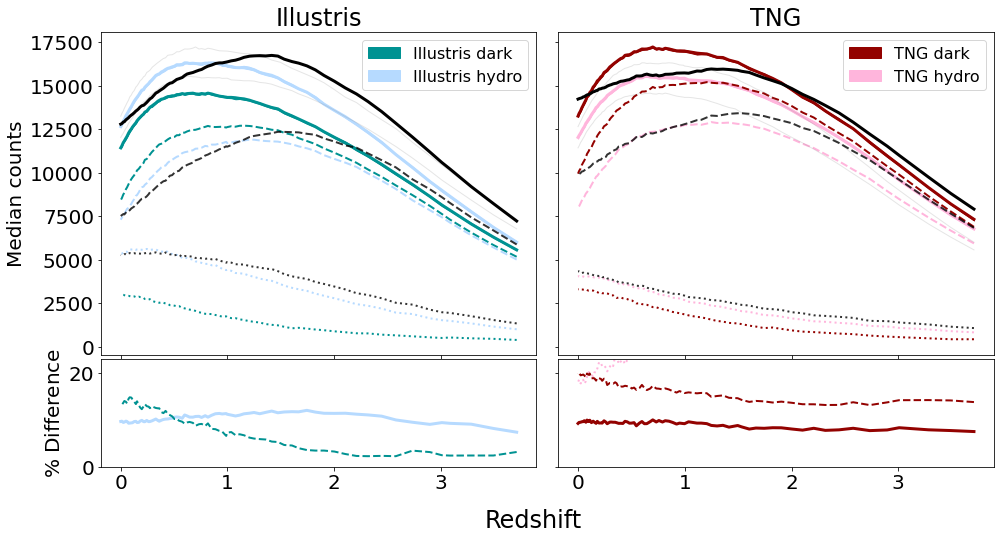

In [23]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1],'wspace': 0.05,"hspace":0.02})

axILL = ax[0][0]
axTNG = ax[0][1]
axilldiff = ax[1][0]
axtngdiff = ax[1][1]

# illd, illh = Illustris['dark'], Illustris['hydro']
# tngd, tngh = TNG['dark'], TNG['hydro']

########################
# Illustris plot first #
########################
axILL.set(title="Illustris", ylabel="Median counts")

axILL.plot(illd['z'],illd['medians'], color=palette["Illustris dark"], lw=3)
axILL.plot(illh['z'],illh['medians'], color=palette["Illustris hydro"], lw=3)

axILL.plot(illd['z'],illd['unpaired'], color=palette["Illustris dark"], lw=2, linestyle="dotted")
axILL.plot(illh['z'],illh['unpaired'], color=palette["Illustris hydro"], lw=2, linestyle="dotted")
axILL.plot(illd['z'],illd['paired'], color=palette["Illustris dark"], lw=2, linestyle="dashed")
axILL.plot(illh['z'],illh['paired'], color=palette["Illustris hydro"], lw=2, linestyle="dashed")

axILL.fill_between(illd['z'], np.array(illd['quartiles'])[:,0], np.array(illd['quartiles'])[:,1],color=palette["Illustris dark"],alpha=1, label="Illustris dark")
axILL.fill_between(illh['z'], np.array(illh['quartiles'])[:,0], np.array(illh['quartiles'])[:,1],color=palette["Illustris hydro"],alpha=1, label="Illustris hydro")

axILL.plot(tngd['z'],tngd['medians'], color='grey',alpha=0.2, lw=1)
axILL.plot(tngh['z'],tngh['medians'], color='grey',alpha=0.2, lw=1)

axILL.plot(illsim['z'],illsim['medians'], color='black', lw=3)
axILL.plot(illsim['z'],illsim['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
axILL.plot(illsim['z'],illsim['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


############
# TNG plot #
############
axTNG.set(title="TNG")
axTNG.plot(tngd['z'],tngd['medians'], color=palette["TNG dark"], lw=3)
axTNG.plot(tngh['z'],tngh['medians'], color=palette["TNG hydro"], lw=3)

axTNG.plot(tngd['z'],tngd['unpaired'], color=palette["TNG dark"], lw=2, linestyle="dotted")
axTNG.plot(tngh['z'],tngh['unpaired'], color=palette["TNG hydro"], lw=2, linestyle="dotted")
axTNG.plot(tngd['z'],tngd['paired'], color=palette["TNG dark"], lw=2, linestyle="dashed")
axTNG.plot(tngh['z'],tngh['paired'], color=palette["TNG hydro"], lw=2, linestyle="dashed")

axTNG.fill_between(tngd['z'], np.array(tngd['quartiles'])[:,0], np.array(tngd['quartiles'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
axTNG.fill_between(tngh['z'], np.array(tngh['quartiles'])[:,0], np.array(tngh['quartiles'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

axTNG.plot(illd['z'],illd['medians'], color='grey',alpha=0.2, lw=1)
axTNG.plot(illh['z'],illh['medians'], color='grey',alpha=0.2, lw=1)

axTNG.plot(tngsim['z'],tngsim['medians'], color='black', lw=3)
axTNG.plot(tngsim['z'],tngsim['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
axTNG.plot(tngsim['z'],tngsim['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


########################
# Illustris difference #
########################
axilldiff.set(ylabel=r"$\%$ Difference")
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['medians'])-np.array(illh['medians']) )/np.array(illh['medians']), color=palette["Illustris hydro"], lw=3)
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) )/np.array(illh['unpaired']), color=palette["Illustris hydro"], lw=2, linestyle='dotted')
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['paired'])-np.array(illh['paired']) )/np.array(illd['paired']), color=palette["Illustris dark"], lw=2, linestyle='dashed')


########################
# Illustris difference #
########################
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['medians'])-np.array(tngh['medians']) )/np.array(tngd['medians']), color=palette["TNG dark"], lw=3)
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) )/np.array(tngh['unpaired']), color=palette["TNG hydro"], lw=2, linestyle='dotted')
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) )/np.array(tngd['paired']), color=palette["TNG dark"], lw=2, linestyle='dashed')
axtngdiff.set_ylim(0,23)

axILL.legend(loc="upper right",fontsize=16)
axTNG.legend(loc="upper right",fontsize=16)
fig.supxlabel("Redshift")
plt.savefig(f"../plots/counts/groupcut_d.png",bbox_inches='tight',facecolor="white")
plt.show()


## Massive

In [24]:
illd = get_counts("Illustris", "dark", "massive")
illh = get_counts("Illustris", "hydro", "massive")
print("done with Illustris")


tngd = get_counts("TNG", "dark", "massive")
tngh = get_counts("TNG", "hydro", "massive")
print("done with tng")

print("starting stars")
illsim = get_counts_simstell("Illustris", "massive")
print("done with ill")
tngsim = get_counts_simstell("TNG", "massive")
print("done with tng")


done with Illustris
done with tng
starting stars
done with ill
done with tng


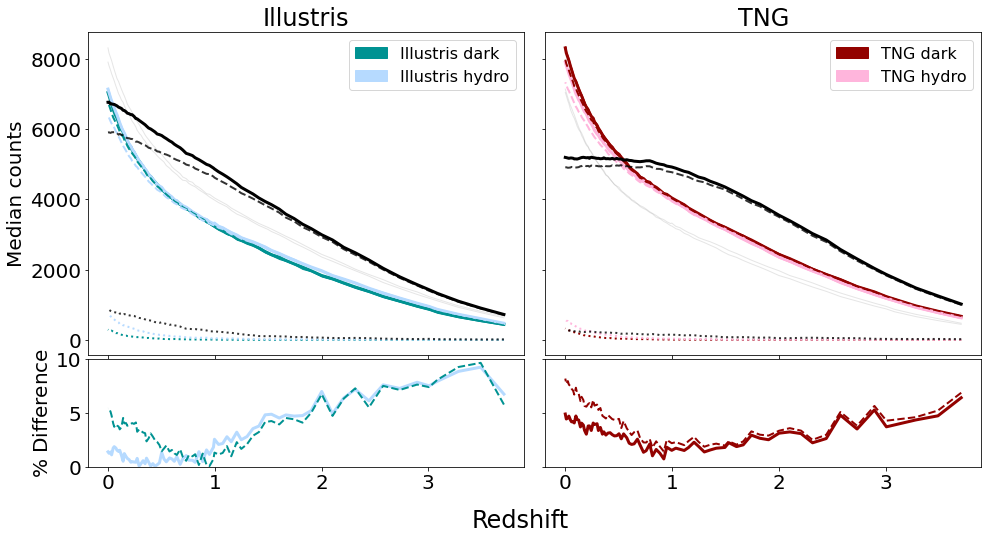

In [25]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1],'wspace': 0.05,"hspace":0.02})

axILL = ax[0][0]
axTNG = ax[0][1]
axilldiff = ax[1][0]
axtngdiff = ax[1][1]

# illd, illh = Illustris['dark'], Illustris['hydro']
# tngd, tngh = TNG['dark'], TNG['hydro']

########################
# Illustris plot first #
########################
axILL.set(title="Illustris", ylabel="Median counts")

axILL.plot(illd['z'],illd['medians'], color=palette["Illustris dark"], lw=3)
axILL.plot(illh['z'],illh['medians'], color=palette["Illustris hydro"], lw=3)

axILL.plot(illd['z'],illd['unpaired'], color=palette["Illustris dark"], lw=2, linestyle="dotted")
axILL.plot(illh['z'],illh['unpaired'], color=palette["Illustris hydro"], lw=2, linestyle="dotted")
axILL.plot(illd['z'],illd['paired'], color=palette["Illustris dark"], lw=2, linestyle="dashed")
axILL.plot(illh['z'],illh['paired'], color=palette["Illustris hydro"], lw=2, linestyle="dashed")

axILL.fill_between(illd['z'], np.array(illd['quartiles'])[:,0], np.array(illd['quartiles'])[:,1],color=palette["Illustris dark"],alpha=1, label="Illustris dark")
axILL.fill_between(illh['z'], np.array(illh['quartiles'])[:,0], np.array(illh['quartiles'])[:,1],color=palette["Illustris hydro"],alpha=1, label="Illustris hydro")

axILL.plot(tngd['z'],tngd['medians'], color='grey',alpha=0.2, lw=1)
axILL.plot(tngh['z'],tngh['medians'], color='grey',alpha=0.2, lw=1)

axILL.plot(illsim['z'],illsim['medians'], color='black', lw=3)
axILL.plot(illsim['z'],illsim['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
axILL.plot(illsim['z'],illsim['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


############
# TNG plot #
############
axTNG.set(title="TNG")
axTNG.plot(tngd['z'],tngd['medians'], color=palette["TNG dark"], lw=3)
axTNG.plot(tngh['z'],tngh['medians'], color=palette["TNG hydro"], lw=3)

axTNG.plot(tngd['z'],tngd['unpaired'], color=palette["TNG dark"], lw=2, linestyle="dotted")
axTNG.plot(tngh['z'],tngh['unpaired'], color=palette["TNG hydro"], lw=2, linestyle="dotted")
axTNG.plot(tngd['z'],tngd['paired'], color=palette["TNG dark"], lw=2, linestyle="dashed")
axTNG.plot(tngh['z'],tngh['paired'], color=palette["TNG hydro"], lw=2, linestyle="dashed")

axTNG.fill_between(tngd['z'], np.array(tngd['quartiles'])[:,0], np.array(tngd['quartiles'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
axTNG.fill_between(tngh['z'], np.array(tngh['quartiles'])[:,0], np.array(tngh['quartiles'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

axTNG.plot(illd['z'],illd['medians'], color='grey',alpha=0.2, lw=1)
axTNG.plot(illh['z'],illh['medians'], color='grey',alpha=0.2, lw=1)

axTNG.plot(tngsim['z'],tngsim['medians'], color='black', lw=3)
axTNG.plot(tngsim['z'],tngsim['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
axTNG.plot(tngsim['z'],tngsim['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


########################
# Illustris difference #
########################
axilldiff.set(ylabel=r"$\%$ Difference")
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['medians'])-np.array(illh['medians']) )/np.array(illh['medians']), color=palette["Illustris hydro"], lw=3)
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) )/np.array(illh['unpaired']), color=palette["Illustris hydro"], lw=2, linestyle='dotted')
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['paired'])-np.array(illh['paired']) )/np.array(illd['paired']), color=palette["Illustris dark"], lw=2, linestyle='dashed')


########################
# Illustris difference #
########################
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['medians'])-np.array(tngh['medians']) )/np.array(tngd['medians']), color=palette["TNG dark"], lw=3)
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) )/np.array(tngh['unpaired']), color=palette["TNG hydro"], lw=2, linestyle='dotted')
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) )/np.array(tngd['paired']), color=palette["TNG dark"], lw=2, linestyle='dashed')
axtngdiff.set_ylim(0,10)

axILL.legend(loc="upper right",fontsize=16)
axTNG.legend(loc="upper right",fontsize=16)
fig.supxlabel("Redshift")
plt.savefig(f"../plots/counts/no_groupcut_m.png",bbox_inches='tight',facecolor="white")
plt.show()


In [26]:
illd = get_counts("Illustris", "dark", "massive",groupCut=True)
illh = get_counts("Illustris", "hydro", "massive",groupCut=True)
print("done with Illustris")


tngd = get_counts("TNG", "dark", "massive",groupCut=True)
tngh = get_counts("TNG", "hydro", "massive",groupCut=True)
print("done with tng")

print("starting stars")
illsim = get_counts_simstell("Illustris", "massive",groupCut=True)
print("done with ill")
tngsim = get_counts_simstell("TNG", "massive",groupCut=True)
print("done with tng")


done with Illustris
done with tng
starting stars
done with ill
done with tng


In [1]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(2, 2, figsize=(16,8), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1],'wspace': 0.05,"hspace":0.02})

axILL = ax[0][0]
axTNG = ax[0][1]
axilldiff = ax[1][0]
axtngdiff = ax[1][1]

# illd, illh = Illustris['dark'], Illustris['hydro']
# tngd, tngh = TNG['dark'], TNG['hydro']

########################
# Illustris plot first #
########################
axILL.set(title="Illustris", ylabel="Median counts")

axILL.plot(illd['z'],illd['medians'], color=palette["Illustris dark"], lw=3)
axILL.plot(illh['z'],illh['medians'], color=palette["Illustris hydro"], lw=3)

axILL.plot(illd['z'],illd['unpaired'], color=palette["Illustris dark"], lw=2, linestyle="dotted")
axILL.plot(illh['z'],illh['unpaired'], color=palette["Illustris hydro"], lw=2, linestyle="dotted")
axILL.plot(illd['z'],illd['paired'], color=palette["Illustris dark"], lw=2, linestyle="dashed")
axILL.plot(illh['z'],illh['paired'], color=palette["Illustris hydro"], lw=2, linestyle="dashed")

axILL.fill_between(illd['z'], np.array(illd['quartiles'])[:,0], np.array(illd['quartiles'])[:,1],color=palette["Illustris dark"],alpha=1, label="Illustris dark")
axILL.fill_between(illh['z'], np.array(illh['quartiles'])[:,0], np.array(illh['quartiles'])[:,1],color=palette["Illustris hydro"],alpha=1, label="Illustris hydro")

axILL.plot(tngd['z'],tngd['medians'], color='grey',alpha=0.2, lw=1)
axILL.plot(tngh['z'],tngh['medians'], color='grey',alpha=0.2, lw=1)

axILL.plot(illsim['z'],illsim['medians'], color='black', lw=3)
axILL.plot(illsim['z'],illsim['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
axILL.plot(illsim['z'],illsim['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


############
# TNG plot #
############
axTNG.set(title="TNG")
axTNG.plot(tngd['z'],tngd['medians'], color=palette["TNG dark"], lw=3)
axTNG.plot(tngh['z'],tngh['medians'], color=palette["TNG hydro"], lw=3)

axTNG.plot(tngd['z'],tngd['unpaired'], color=palette["TNG dark"], lw=2, linestyle="dotted")
axTNG.plot(tngh['z'],tngh['unpaired'], color=palette["TNG hydro"], lw=2, linestyle="dotted")
axTNG.plot(tngd['z'],tngd['paired'], color=palette["TNG dark"], lw=2, linestyle="dashed")
axTNG.plot(tngh['z'],tngh['paired'], color=palette["TNG hydro"], lw=2, linestyle="dashed")

axTNG.fill_between(tngd['z'], np.array(tngd['quartiles'])[:,0], np.array(tngd['quartiles'])[:,1],color=palette["TNG dark"],alpha=1, label="TNG dark")
axTNG.fill_between(tngh['z'], np.array(tngh['quartiles'])[:,0], np.array(tngh['quartiles'])[:,1],color=palette["TNG hydro"],alpha=1, label="TNG hydro")

axTNG.plot(illd['z'],illd['medians'], color='grey',alpha=0.2, lw=1)
axTNG.plot(illh['z'],illh['medians'], color='grey',alpha=0.2, lw=1)

axTNG.plot(tngsim['z'],tngsim['medians'], color='black', lw=3)
axTNG.plot(tngsim['z'],tngsim['paired'], color='black',linestyle='dashed', lw=2,alpha=0.8)
axTNG.plot(tngsim['z'],tngsim['unpaired'], color='black',linestyle='dotted', lw=2,alpha=0.8)


########################
# Illustris difference #
########################
axilldiff.set(ylabel=r"$\%$ Difference")
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['medians'])-np.array(illh['medians']) )/np.array(illh['medians']), color=palette["Illustris hydro"], lw=3)
# axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['unpaired'])-np.array(illh['unpaired']) )/np.array(illh['unpaired']), color=palette["Illustris hydro"], lw=2, linestyle='dotted')
axilldiff.plot(illd['z'], 100*np.abs( np.array(illd['paired'])-np.array(illh['paired']) )/np.array(illd['paired']), color=palette["Illustris dark"], lw=2, linestyle='dashed')


########################
# Illustris difference #
########################
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['medians'])-np.array(tngh['medians']) )/np.array(tngd['medians']), color=palette["TNG dark"], lw=3)
# axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['unpaired'])-np.array(tngh['unpaired']) )/np.array(tngh['unpaired']), color=palette["TNG hydro"], lw=2, linestyle='dotted')
axtngdiff.plot(tngd['z'], 100*np.abs( np.array(tngd['paired'])-np.array(tngh['paired']) )/np.array(tngd['paired']), color=palette["TNG dark"], lw=2, linestyle='dashed')
axtngdiff.set_ylim(0,10)

axILL.legend(loc="upper right",fontsize=16)
axTNG.legend(loc="upper right",fontsize=16)
fig.supxlabel("Redshift")
plt.savefig(f"../plots/counts/groupcut_m.png",bbox_inches='tight',facecolor="white")
plt.show()


NameError: name 'plt' is not defined

___
$\quad$

$\quad$
# Pair ratios


get_counts() will give the total number of primaries at a redshift. at each z, need counts 

## Dwarfs

In [ ]:
kwarg_dict = {"groupCut": True, 
              "median":False, 
              "errorprint":False, 
              "redshiftcutoff":True}

size = "dwarf"

illd = get_paircounts("Illustris", "dark", size, **kwarg_dict)
illh = get_paircounts("Illustris", "hydro", size, **kwarg_dict)
print("done with Illustris")

tngd = get_paircounts("TNG", "dark", size, **kwarg_dict)
tngh = get_paircounts("TNG", "hydro", size, **kwarg_dict)
print("done with TNG")

illsim = get_paircounts_simstell("Illustris", size, **kwarg_dict)
tngsim = get_paircounts_simstell("TNG", size, **kwarg_dict)
print("done with stars")

In [ ]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.1,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]

axtngmaj = ax[3][0]
axtngmin = ax[3][1]

axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

al = 0.5

###################
# Illustris major #
###################
axillmaj.set(title="Major", ylabel="Pair frac")
axillmaj.plot(illd['z'],illd['Fraction Majors'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Fraction Majors'], color=palette["Illustris hydro"], lw=3)
axillmaj.plot(illsim['z'],illsim['Fraction Majors'], color='black', lw=1)

axillmaj.fill_between(illd['z'], np.array(illd['Quarts Fraction Majors'])[:,0], np.array(illd['Quarts Fraction Majors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Quarts Fraction Majors'])[:,0]-np.array(illd['Quarts Fraction Majors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Majors'])[:,1]-np.array(illd['Quarts Fraction Majors'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illd['Fraction Majors'])-np.array(illh['Fraction Majors']) ), color=palette["Illustris dark"], lw=3)
axillmajdiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.set(title="Minor")
axillmin.plot(illd['z'],illd['Fraction Minors'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Fraction Minors'], color=palette["Illustris hydro"], lw=3)
axillmin.plot(illsim['z'],illsim['Fraction Minors'], color='black', lw=1)

axillmin.fill_between(illd['z'], np.array(illd['Quarts Fraction Minors'])[:,0], np.array(illd['Quarts Fraction Minors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Quarts Fraction Minors'])[:,0]-np.array(illd['Quarts Fraction Minors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Minors'])[:,1]-np.array(illd['Quarts Fraction Minors'])[:,0]

axillmindiff.plot(illd['z'], (np.array(illd['Fraction Minors'])-np.array(illh['Fraction Minors']) ), color=palette["Illustris dark"], lw=3)
axillmindiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


#############
# TNG major #
#############
axtngmaj.set(ylabel="Pair frac")
axtngmaj.plot(tngd['z'],tngd['Fraction Majors'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Fraction Majors'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color='black', lw=1)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Majors'])[:,0], np.array(tngd['Quarts Fraction Majors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Majors'])[:,0], np.array(tngh['Quarts Fraction Majors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngd['Quarts Fraction Majors'])[:,0]-np.array(tngh['Quarts Fraction Majors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Majors'])[:,1]-np.array(tngh['Quarts Fraction Majors'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngd['Fraction Majors'])-np.array(tngh['Fraction Majors']) ), color=palette["TNG dark"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Fraction Minors'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Fraction Minors'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color='black', lw=1)

axtngmin.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Minors'])[:,0], np.array(tngd['Quarts Fraction Minors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngd['Quarts Fraction Minors'])[:,0]-np.array(tngh['Quarts Fraction Minors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Minors'])[:,1]-np.array(tngh['Quarts Fraction Minors'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngd['Fraction Minors'])-np.array(tngh['Fraction Minors']) ), color=palette["TNG dark"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper left",fontsize=16)
axtngmin.legend(title="TNG",loc="upper left",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/counts/pairfrac_majorminor_d_100Rvir.png",bbox_inches='tight',facecolor="white")
plt.show()


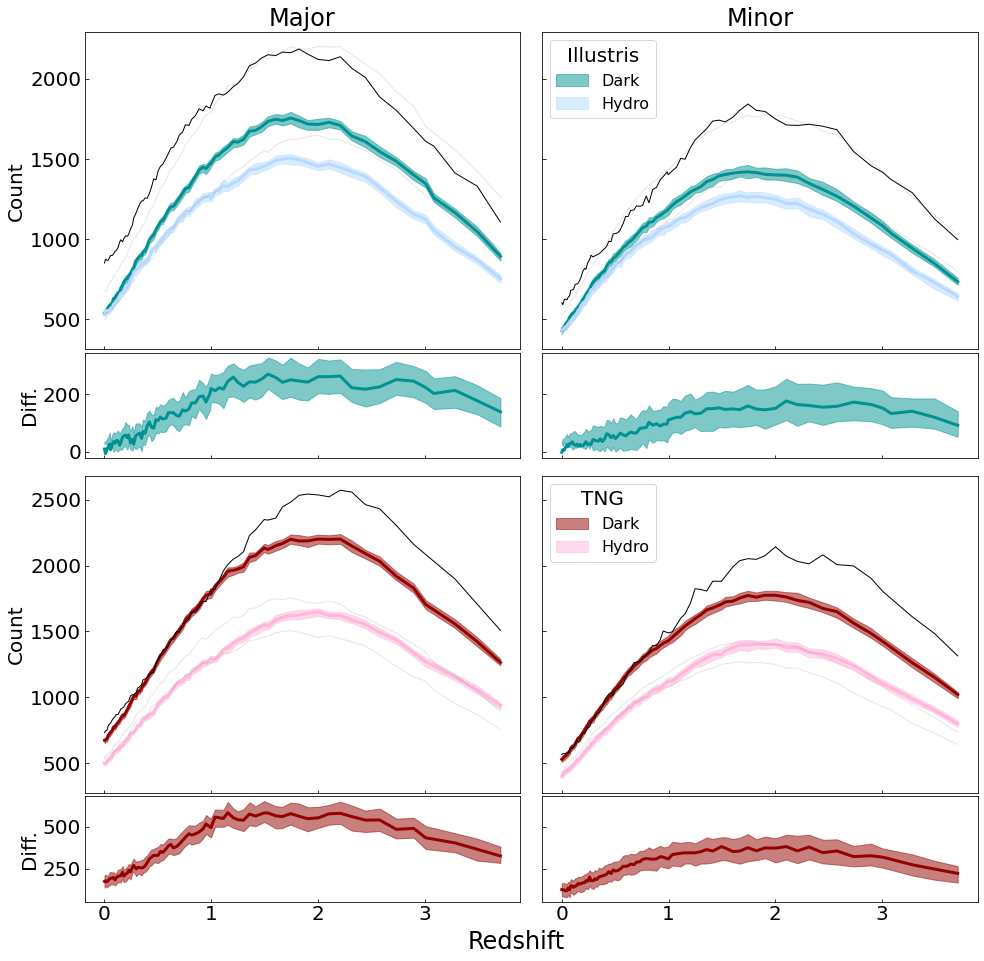

In [15]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.1,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]

axtngmaj = ax[3][0]
axtngmin = ax[3][1]

axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

al = 0.5

###################
# Illustris major #
###################
axillmaj.set(title="Major", ylabel="Count")
axillmaj.plot(illd['z'],illd['Number Majors'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Number Majors'], color=palette["Illustris hydro"], lw=3)
axillmaj.plot(illsim['z'],illsim['Number Majors'], color='black', lw=1)

axillmaj.fill_between(illd['z'], np.array(illd['Quarts Majors'])[:,0], np.array(illd['Quarts Majors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Quarts Majors'])[:,0], np.array(illh['Quarts Majors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Number Majors'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Number Majors"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Quarts Majors'])[:,0]-np.array(illd['Quarts Majors'])[:,1]
highdiff = np.array(illh['Quarts Majors'])[:,1]-np.array(illd['Quarts Majors'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illd['Number Majors'])-np.array(illh['Number Majors']) ), color=palette["Illustris dark"], lw=3)
axillmajdiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.set(title="Minor")
axillmin.plot(illd['z'],illd['Number Minors'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Number Minors'], color=palette["Illustris hydro"], lw=3)
axillmin.plot(illsim['z'],illsim['Number Minors'], color='black', lw=1)

axillmin.fill_between(illd['z'], np.array(illd['Quarts Minors'])[:,0], np.array(illd['Quarts Minors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Quarts Minors'])[:,0], np.array(illh['Quarts Minors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Number Minors'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Number Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Quarts Minors'])[:,0]-np.array(illd['Quarts Minors'])[:,1]
highdiff = np.array(illh['Quarts Minors'])[:,1]-np.array(illd['Quarts Minors'])[:,0]

axillmindiff.plot(illd['z'], (np.array(illd['Number Minors'])-np.array(illh['Number Minors']) ), color=palette["Illustris dark"], lw=3)
axillmindiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


#############
# TNG major #
#############
axtngmaj.set(ylabel="Count")
axtngmaj.plot(tngd['z'],tngd['Number Majors'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Number Majors'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Number Majors'], color='black', lw=1)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Quarts Majors'])[:,0], np.array(tngd['Quarts Majors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Quarts Majors'])[:,0], np.array(tngh['Quarts Majors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Number Majors'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Number Majors"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngd['Quarts Majors'])[:,0]-np.array(tngh['Quarts Majors'])[:,1]
highdiff = np.array(tngd['Quarts Majors'])[:,1]-np.array(tngh['Quarts Majors'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngd['Number Majors'])-np.array(tngh['Number Majors']) ), color=palette["TNG dark"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Number Minors'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Number Minors'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(tngsim['z'],tngsim['Number Minors'], color='black', lw=1)

axtngmin.fill_between(tngd['z'], np.array(tngd['Quarts Minors'])[:,0], np.array(tngd['Quarts Minors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Minors'])[:,0], np.array(tngh['Quarts Minors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Number Minors'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Number Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngd['Quarts Minors'])[:,0]-np.array(tngh['Quarts Minors'])[:,1]
highdiff = np.array(tngd['Quarts Minors'])[:,1]-np.array(tngh['Quarts Minors'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngd['Number Minors'])-np.array(tngh['Number Minors']) ), color=palette["TNG dark"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper left",fontsize=16)
axtngmin.legend(title="TNG",loc="upper left",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/counts/paircount_majorminor_d_100.png",bbox_inches='tight',facecolor="white")
plt.show()


## Massive

In [ ]:
kwarg_dict = {"groupCut": True, 
              "median":False, 
              "errorprint":False, 
              "redshiftcutoff":True}

size = "massive"

illd = get_paircounts("Illustris", "dark", size, **kwarg_dict)
illh = get_paircounts("Illustris", "hydro", size, **kwarg_dict)
print("done with Illustris")

tngd = get_paircounts("TNG", "dark", size, **kwarg_dict)
tngh = get_paircounts("TNG", "hydro", size, **kwarg_dict)
print("done with TNG")

illsim = get_paircounts_simstell("Illustris", size, **kwarg_dict)
tngsim = get_paircounts_simstell("TNG", size, **kwarg_dict)
print("done with stars")

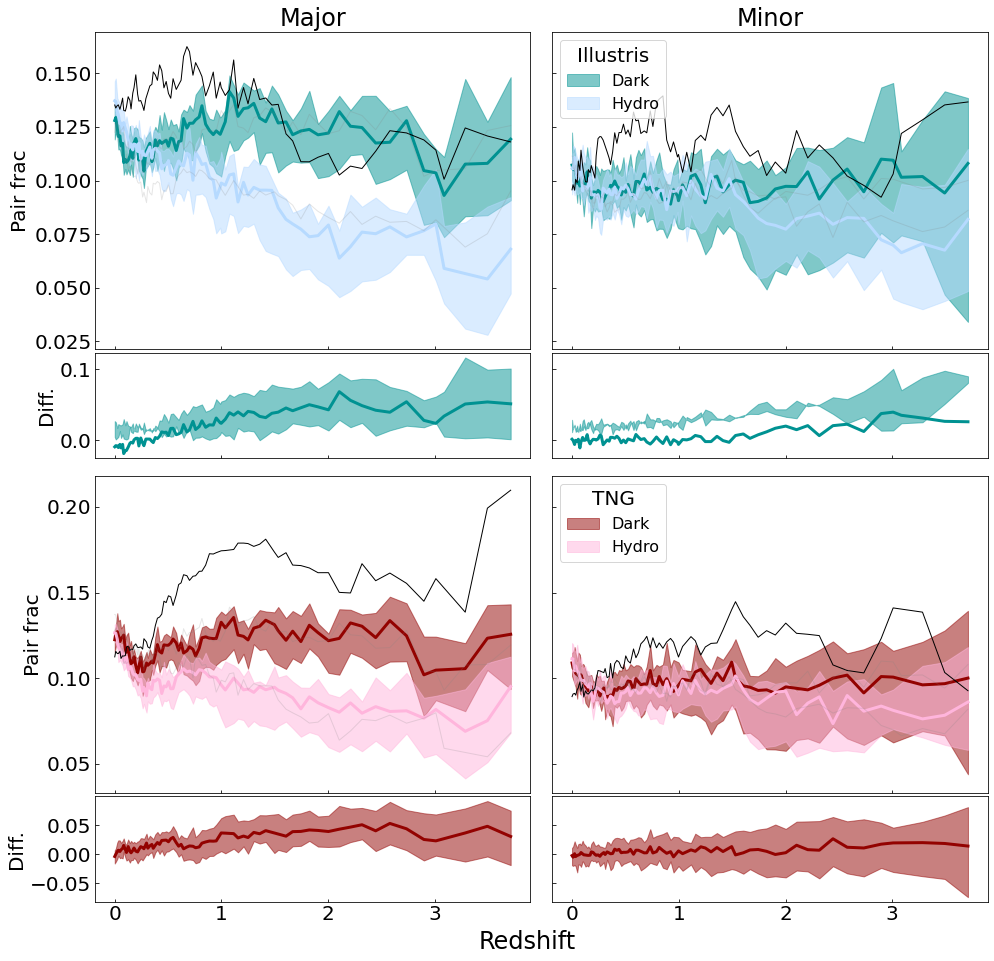

In [69]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.1,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]

axtngmaj = ax[3][0]
axtngmin = ax[3][1]

axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

al = 0.5

###################
# Illustris major #
###################
axillmaj.set(title="Major", ylabel="Pair frac")
axillmaj.plot(illd['z'],illd['Fraction Majors'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Fraction Majors'], color=palette["Illustris hydro"], lw=3)
axillmaj.plot(illsim['z'],illsim['Fraction Majors'], color='black', lw=1)

axillmaj.fill_between(illd['z'], np.array(illd['Quarts Fraction Majors'])[:,0], np.array(illd['Quarts Fraction Majors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Quarts Fraction Majors'])[:,0], np.array(illh['Quarts Fraction Majors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Quarts Fraction Majors'])[:,0]-np.array(illd['Quarts Fraction Majors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Majors'])[:,1]-np.array(illd['Quarts Fraction Majors'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illd['Fraction Majors'])-np.array(illh['Fraction Majors']) ), color=palette["Illustris dark"], lw=3)
axillmajdiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.set(title="Minor")
axillmin.plot(illd['z'],illd['Fraction Minors'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Fraction Minors'], color=palette["Illustris hydro"], lw=3)
axillmin.plot(illsim['z'],illsim['Fraction Minors'], color='black', lw=1)

axillmin.fill_between(illd['z'], np.array(illd['Quarts Fraction Minors'])[:,0], np.array(illd['Quarts Fraction Minors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Quarts Fraction Minors'])[:,0], np.array(illh['Quarts Fraction Minors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Quarts Fraction Minors'])[:,0]-np.array(illd['Quarts Fraction Minors'])[:,1]
highdiff = np.array(illh['Quarts Fraction Minors'])[:,1]-np.array(illd['Quarts Fraction Minors'])[:,0]

axillmindiff.plot(illd['z'], (np.array(illd['Fraction Minors'])-np.array(illh['Fraction Minors']) ), color=palette["Illustris dark"], lw=3)
axillmindiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


#############
# TNG major #
#############
axtngmaj.set(ylabel="Pair frac")
axtngmaj.plot(tngd['z'],tngd['Fraction Majors'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Fraction Majors'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Fraction Majors'], color='black', lw=1)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Majors'])[:,0], np.array(tngd['Quarts Fraction Majors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Majors'])[:,0], np.array(tngh['Quarts Fraction Majors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Fraction Majors'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Fraction Majors"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngd['Quarts Fraction Majors'])[:,0]-np.array(tngh['Quarts Fraction Majors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Majors'])[:,1]-np.array(tngh['Quarts Fraction Majors'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngd['Fraction Majors'])-np.array(tngh['Fraction Majors']) ), color=palette["TNG dark"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Fraction Minors'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Fraction Minors'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(tngsim['z'],tngsim['Fraction Minors'], color='black', lw=1)

axtngmin.fill_between(tngd['z'], np.array(tngd['Quarts Fraction Minors'])[:,0], np.array(tngd['Quarts Fraction Minors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Fraction Minors'])[:,0], np.array(tngh['Quarts Fraction Minors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Fraction Minors'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Fraction Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngd['Quarts Fraction Minors'])[:,0]-np.array(tngh['Quarts Fraction Minors'])[:,1]
highdiff = np.array(tngd['Quarts Fraction Minors'])[:,1]-np.array(tngh['Quarts Fraction Minors'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngd['Fraction Minors'])-np.array(tngh['Fraction Minors']) ), color=palette["TNG dark"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper left",fontsize=16)
axtngmin.legend(title="TNG",loc="upper left",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/counts/pairfrac_majorminor_m_100Rvir.png.png",bbox_inches='tight',facecolor="white")
plt.show()


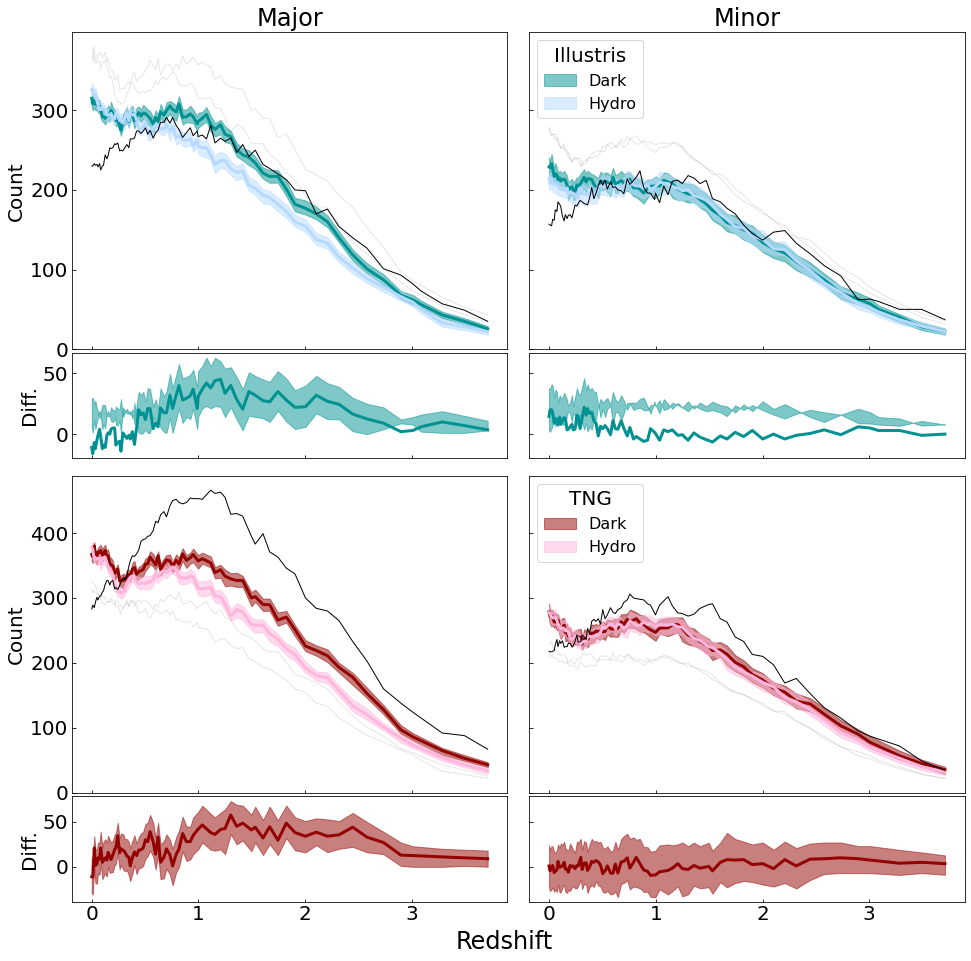

In [18]:
## plot of median counts and differences for illustris and tng
fig, ax = plt.subplots(5, 2, figsize=(16,16), sharey='row', sharex=True, gridspec_kw={'width_ratios': [1,1], 'height_ratios':[3,1,0.1,3,1],'wspace': 0.05,"hspace":0.02})

# blank = ax[2]
for i in ax[2]:
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)
    i.spines['left'].set_visible(False)
    i.spines['bottom'].set_visible(False)
    i.get_xaxis().set_visible(False)
    i.get_yaxis().set_visible(False)

axillmaj = ax[0][0]
axillmin = ax[0][1]

axillmajdiff = ax[1][0]
axillmindiff = ax[1][1]

axtngmaj = ax[3][0]
axtngmin = ax[3][1]

axtngmajdiff = ax[4][0]
axtngmindiff = ax[4][1]

al = 0.5

###################
# Illustris major #
###################
axillmaj.set(title="Major", ylabel="Count")
axillmaj.plot(illd['z'],illd['Number Majors'], color=palette["Illustris dark"], lw=3)
axillmaj.plot(illh['z'],illh['Number Majors'], color=palette["Illustris hydro"], lw=3)
axillmaj.plot(illsim['z'],illsim['Number Majors'], color='black', lw=1)

axillmaj.fill_between(illd['z'], np.array(illd['Quarts Majors'])[:,0], np.array(illd['Quarts Majors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmaj.fill_between(illh['z'], np.array(illh['Quarts Majors'])[:,0], np.array(illh['Quarts Majors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmaj.plot(tngd['z'],tngd['Number Majors'], color='grey',alpha=0.2, lw=1)
axillmaj.plot(tngh['z'],tngh["Number Majors"], color='grey',alpha=0.2, lw=1)

axillmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(illh['Quarts Majors'])[:,0]-np.array(illd['Quarts Majors'])[:,1]
highdiff = np.array(illh['Quarts Majors'])[:,1]-np.array(illd['Quarts Majors'])[:,0]

axillmajdiff.plot(illd['z'], (np.array(illd['Number Majors'])-np.array(illh['Number Majors']) ), color=palette["Illustris dark"], lw=3)
axillmajdiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


###################
# Illustris minor #
###################
axillmin.set(title="Minor")
axillmin.plot(illd['z'],illd['Number Minors'], color=palette["Illustris dark"], lw=3)
axillmin.plot(illh['z'],illh['Number Minors'], color=palette["Illustris hydro"], lw=3)
axillmin.plot(illsim['z'],illsim['Number Minors'], color='black', lw=1)

axillmin.fill_between(illd['z'], np.array(illd['Quarts Minors'])[:,0], np.array(illd['Quarts Minors'])[:,1],color=palette["Illustris dark"],alpha=al, label="Dark")
axillmin.fill_between(illh['z'], np.array(illh['Quarts Minors'])[:,0], np.array(illh['Quarts Minors'])[:,1],color=palette["Illustris hydro"],alpha=al, label="Hydro")

axillmin.plot(tngd['z'],tngd['Number Minors'], color='grey',alpha=0.2, lw=1)
axillmin.plot(tngh['z'],tngh["Number Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(illh['Quarts Minors'])[:,0]-np.array(illd['Quarts Minors'])[:,1]
highdiff = np.array(illh['Quarts Minors'])[:,1]-np.array(illd['Quarts Minors'])[:,0]

axillmindiff.plot(illd['z'], (np.array(illd['Number Minors'])-np.array(illh['Number Minors']) ), color=palette["Illustris dark"], lw=3)
axillmindiff.fill_between(illd['z'], abs(lowdiff), abs(highdiff),color=palette["Illustris dark"],alpha=al, label="Dark")


#############
# TNG major #
#############
axtngmaj.set(ylabel="Count")
axtngmaj.plot(tngd['z'],tngd['Number Majors'], color=palette["TNG dark"], lw=3)
axtngmaj.plot(tngh['z'],tngh['Number Majors'], color=palette["TNG hydro"], lw=3)
axtngmaj.plot(tngsim['z'],tngsim['Number Majors'], color='black', lw=1)

axtngmaj.fill_between(tngd['z'], np.array(tngd['Quarts Majors'])[:,0], np.array(tngd['Quarts Majors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmaj.fill_between(tngh['z'], np.array(tngh['Quarts Majors'])[:,0], np.array(tngh['Quarts Majors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmaj.plot(illd['z'],illd['Number Majors'], color='grey',alpha=0.2, lw=1)
axtngmaj.plot(illh['z'],illh["Number Majors"], color='grey',alpha=0.2, lw=1)

axtngmajdiff.set(ylabel=r"Diff.")
lowdiff = np.array(tngd['Quarts Majors'])[:,0]-np.array(tngh['Quarts Majors'])[:,1]
highdiff = np.array(tngd['Quarts Majors'])[:,1]-np.array(tngh['Quarts Majors'])[:,0]

axtngmajdiff.plot(tngd['z'], (np.array(tngd['Number Majors'])-np.array(tngh['Number Majors']) ), color=palette["TNG dark"], lw=3)
axtngmajdiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
# TNG minor #
#############
axtngmin.plot(tngd['z'],tngd['Number Minors'], color=palette["TNG dark"], lw=3)
axtngmin.plot(tngh['z'],tngh['Number Minors'], color=palette["TNG hydro"], lw=3)
axtngmin.plot(tngsim['z'],tngsim['Number Minors'], color='black', lw=1)

axtngmin.fill_between(tngd['z'], np.array(tngd['Quarts Minors'])[:,0], np.array(tngd['Quarts Minors'])[:,1],color=palette["TNG dark"],alpha=al, label="Dark")
axtngmin.fill_between(tngh['z'], np.array(tngh['Quarts Minors'])[:,0], np.array(tngh['Quarts Minors'])[:,1],color=palette["TNG hydro"],alpha=al, label="Hydro")

axtngmin.plot(illd['z'],illd['Number Minors'], color='grey',alpha=0.2, lw=1)
axtngmin.plot(illh['z'],illh["Number Minors"], color='grey',alpha=0.2, lw=1)

lowdiff = np.array(tngd['Quarts Minors'])[:,0]-np.array(tngh['Quarts Minors'])[:,1]
highdiff = np.array(tngd['Quarts Minors'])[:,1]-np.array(tngh['Quarts Minors'])[:,0]

axtngmindiff.plot(tngd['z'], (np.array(tngd['Number Minors'])-np.array(tngh['Number Minors']) ), color=palette["TNG dark"], lw=3)
axtngmindiff.fill_between(tngd['z'], lowdiff, highdiff,color=palette["TNG dark"],alpha=al, label="Dark")


#############
#############
axillmin.legend(title="Illustris",loc="upper left",fontsize=16)
axtngmin.legend(title="TNG",loc="upper left",fontsize=16)
fig.supxlabel("Redshift",y=0.08)
plt.savefig(f"../plots/counts/paircount_majorminor_m_100.png",bbox_inches='tight',facecolor="white")
plt.show()


## debug

In [39]:
sim="Illustris"
snap=135
phys="hydro"
pair_path = f"{sim}_{snap}_10.hdf5"
pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")

In [41]:
unpair = pair_data["unpaired"][phys]
unpairStells = np.array(unpair["Sub1 Stellar Mass"])
unpairGroups = np.array(unpair["Group Mass"])
unpairReals = np.array(unpair['Realization'])

pair = pair_data["pairs"][phys]
priStell = np.array(pair["Sub1 Stellar Mass"])
secStell = np.array(pair["Sub2 Stellar Mass"])
pairGroups = np.array(pair["Group Mass"])
pairReals = np.array(pair["Realization"])

In [43]:
# subset masks for unpaired
unpair_pri = get_primmask(unpairStells, size)
unpair_group = get_groupmask(unpairGroups, size)                
unpair_medreal = unpairReals == -1

pair_pri = get_primmask(priStell, size)
pair_group = get_groupmask(pairGroups, size)
pair_medreal = pairReals == -1

majors = (secStell/priStell > 1/4)
minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)


# defining combined masks 
unpair_mask = unpair_pri
pair_mask = pair_pri

In [44]:
groupCut = True
median = False

In [46]:
if groupCut:
    unpair_mask = unpair_mask & unpair_group
    pair_mask = pair_mask & pair_group

if median:
    unpair_mask = unpair_mask & unpair_medreal
    pair_mask = pair_mask & pair_medreal

    num_unpair = np.count_nonzero(unpair_mask)
    num_pair = np.count_nonzero(pair_mask)   
    num_maj = np.count_nonzero(pair_mask & majors)   
    num_min = np.count_nonzero(pair_mask & minors)   

    numPri_z = num_pair + num_unpair
    numAll_z = num_pair
    numMaj_z = num_maj
    numMin_z = num_min
    fracAll_z = numAll_z / numPri_z
    fracMaj_z = numMaj_z / numPri_z
    fracMin_z = numMin_z / numPri_z
    quartAll_z, quartPri_z, quartMaj_z, quartMin_z  = [0,0], [0,0], [0,0], [0,0]
    quartfracAll_z, quartfracMaj_z, quartfracMin_z = [0,0], [0,0], [0,0]

elif ~median:
    pri_perreal, all_perreal, maj_perreal, min_perreal = [], [], [], []
    fracall_perreal, fracmaj_perreal, fracmin_perreal = [], [], []

    realizations = np.unique( unpairReals )

    for real in realizations:                  
        # make realization masks
        unpair_real = unpairReals == real
        pair_real = pairReals == real

        # make copies of masks
        unpair_mask_real = unpair_mask & unpair_real
        pair_mask_real = pair_mask & pair_real

        num_unpair_real = np.count_nonzero(unpair_mask_real)
        num_pair_real = np.count_nonzero(pair_mask_real)   
        num_maj_real = np.count_nonzero(pair_mask_real & majors)   
        num_min_real = np.count_nonzero(pair_mask_real & minors)  
        num_pri_real = num_unpair_real + num_pair_real

        pri_perreal.append( num_pri_real )
        all_perreal.append( num_pair_real )
        maj_perreal.append( num_maj_real )
        min_perreal.append( num_min_real )
        fracall_perreal.append( num_pair_real / num_pri_real )
        fracmaj_perreal.append( num_maj_real / num_pri_real )
        fracmin_perreal.append( num_min_real / num_pri_real )

    numPri_z = np.median( pri_perreal )
    numAll_z = np.median( all_perreal )
    numMaj_z = np.median( maj_perreal )
    numMin_z = np.median( min_perreal )
    fracAll_z = np.median( fracall_perreal )
    fracMaj_z = np.median( fracmaj_perreal )
    fracMin_z = np.median( fracmin_perreal )

    quartPri_z = np.percentile( numPri_z, [16,84])
    quartAll_z = np.percentile( numAll_z, [16,84])
    quartMaj_z = np.percentile( numMaj_z, [16,84])
    quartMin_z = np.percentile( numMin_z, [16,84])
    quartfracAll_z = np.percentile( fracAll_z, [16,84])
    quartfracMaj_z = np.percentile( fracMaj_z, [16,84])
    quartfracMin_z = np.percentile( fracMin_z, [16,84])




In [50]:
fracMaj_z

0.041258387329321314

In [36]:
pair_path = f"Illustris_135_10.hdf5"
pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")

snapshot = 135

In [37]:
unpair = pair_data["unpaired"]["hydro"]
unpairStells = np.array(unpair["Sub1 Stellar Mass"])
unpairGroups = np.array(unpair["Group Mass"])
unpairReals = np.array(unpair['Realization'])

pair = pair_data["pairs"]["hydro"]
priStell = np.array(pair["Sub1 Stellar Mass"])
secStell = np.array(pair["Sub2 Stellar Mass"])
pairGroups = np.array(pair["Group Mass"])
pairReals = np.array(pair["Realization"])

In [38]:
# subset masks for unpaired
unpair_pri = get_primmask(unpairStells, "dwarf")
unpair_group = get_groupmask(unpairGroups, "dwarf")                
unpair_medreal = unpairReals == -1

pair_pri = get_primmask(priStell, "dwarf")
pair_group = get_groupmask(pairGroups, "dwarf")
pair_medreal = pairReals == -1

majors = (secStell/priStell > 1/4)
minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)

In [50]:
groupCut = False
# defining combined masks 
unpair_mask = unpair_pri
pair_mask = pair_pri

if groupCut:
    unpair_mask = unpair_mask & unpair_group
    pair_mask = pair_mask & pair_group

unpair_mask = unpair_mask & unpair_medreal
pair_mask = pair_mask & pair_medreal

num_unpair = np.count_nonzero(unpair_mask)
num_pair = np.count_nonzero(pair_mask)   
num_maj = np.count_nonzero(pair_mask & majors)   
num_min = np.count_nonzero(pair_mask & minors)   

numPri_z = num_pair + num_unpair
numAll_z = num_pair
numMaj_z = num_maj
numMin_z = num_min
fracAll_z = numAll_z / numPri_z
fracMaj_z = numMaj_z / numPri_z
fracMin_z = numMin_z / numPri_z
quartAll_z, quartPri_z, quartMaj_z, quartMin_z  = [0,0], [0,0], [0,0], [0,0]
quartfracAll_z, quartfracMaj_z, quartfracMin_z = [0,0], [0,0], [0,0]


In [51]:
numPri_z

12791

In [ ]:
for snap in snapshots:  
    try:
        pair_path = f"{sim}_{snap}_10.hdf5"
        pair_data = h5py.File(f"{paths.path_pairs}{pair_path}", "r")

        if np.size(pair_data) == 0:
            raise EmptyFile

        redshift = pair_data['Header'].attrs['Redshift']

        if redshiftcutoff & ( redshift > redcutoff) :
            raise SkipRedshift

        if (len(pair_data['paired']["hydro"]['Group ID']) == 0):    
            raise EmptyFile


        unpair = pair_data["unpaired"]["hydro"]
        unpairStells = np.array(unpair["Sub1 Stellar Mass"])
        unpairGroups = np.array(unpair["Group Mass"])
        unpairReals = np.array(unpair['Realization'])

        pair = pair_data["paired"]["hydro"]
        priStell = np.array(pair["Sub1 Stellar Mass"])
        secStell = np.array(pair["Sub2 Stellar Mass"])
        pairGroups = np.array(pair["Group Mass"])
        pairReals = np.array(pair["Realization"])


        # subset masks for unpaired
        unpair_pri = get_primmask(unpairStells, size)
        unpair_group = get_groupmask(unpairGroups, size)                
        unpair_medreal = unpairReals == -1

        pair_pri = get_primmask(priStell, size)
        pair_group = get_groupmask(pairGroups, size)
        pair_medreal = pairReals == -1

        majors = (secStell/priStell > 1/4)
        minors = (secStell/priStell > 1/10) & (secStell/priStell < 1/4)


        # defining combined masks 
        unpair_mask = unpair_pri
        pair_mask = pair_pri

        if groupCut:
            unpair_mask = unpair_mask & unpair_group
            pair_mask = pair_mask & pair_group

        unpair_mask = unpair_mask & unpair_medreal
        pair_mask = pair_mask & pair_medreal

        num_unpair = np.count_nonzero(unpair_mask)
        num_pair = np.count_nonzero(pair_mask)   
        num_maj = np.count_nonzero(pair_mask & majors)   
        num_min = np.count_nonzero(pair_mask & minors)   

        numPri_z = num_pair + num_unpair
        numAll_z = num_pair
        numMaj_z = num_maj
        numMin_z = num_min
        fracAll_z = numAll_z / numPri_z
        fracMaj_z = numMaj_z / numPri_z
        fracMin_z = numMin_z / numPri_z
        quartAll_z, quartPri_z, quartMaj_z, quartMin_z  = [0,0], [0,0], [0,0], [0,0]
        quartfracAll_z, quartfracMaj_z, quartfracMin_z = [0,0], [0,0], [0,0]


        redshifts.append( redshift )
        numPri.append( numPri_z )
        numAll.append( numAll_z )
        numMaj.append( numMaj_z )
        numMin.append( numMin_z )
        fracAll.append( fracAll_z )
        fracMaj.append( fracMaj_z )
        fracMin.append( fracMin_z )
        quartPri.append( quartPri_z )
        quartAll.append( quartAll_z )
        quartMaj.append( quartMaj_z )
        quartMin.append( quartMin_z )
        quartfracAll.append( quartfracAll_z )
        quartfracMaj.append( quartfracMaj_z )
        quartfracMin.append( quartfracMin_z )


    except KeyError:
        if errorprint: print(f'skipping {snap} for KeyError. Please debug')
        continue

    except EmptyFile:
        if errorprint: print(f"skipping {snap}, empty file")
        continue

    except SkipRedshift:
        if errorprint: print(f"skipping {snap}, redshift out of range")

count_dictionary = {
        "z": np.array(redshifts),
        "Number Primaries": np.array(numPri),
        "Number Pairs": np.array(numAll),
        "Number Majors": np.array(numMaj),
        "Number Minors": np.array(numMin),
        "Fraction Pairs": np.array(fracAll),
        "Fraction Majors": np.array(fracMaj),
        "Fraction Minors": np.array(fracMin),
        "Quarts Primaries": np.array(quartPri),
        "Quarts Pairs": np.array(quartAll),
        "Quarts Majors": np.array(quartMaj),
        "Quarts Minors": np.array(quartMin),
        "Quarts Fraction Pairs": np.array(quartfracAll),
        "Quarts Fraction Majors": np.array(quartfracMaj),
        "Quarts Fraction Minors": np.array(quartfracMin)}


return count_dictionary

# Scratch

In [15]:
illgr = get_counts("Illustris", "dark", "massive",median=True, groupCut=True)
illnogr = get_counts("Illustris", "dark", "massive",median=True, groupCut=False)


In [16]:
illgr['medians']-illnogr['medians']


array([ -183,  -228,  -292,  -353,  -390,  -428,  -492,  -550,  -567,
        -618,  -633,  -686,  -739,  -806,  -888,  -938, -1007, -1060,
       -1094, -1148, -1212, -1275, -1310, -1359, -1396, -1475, -1521,
       -1551, -1610, -1666, -1685, -1732, -1770, -1824, -1889, -1941,
       -1966, -2043, -2100, -2160, -2214, -2269, -2325, -2367, -2413,
       -2486, -2548, -2606, -2669, -2725, -2794, -2865, -2937, -3016,
       -3103, -3168, -3235, -3443, -3533, -3607, -3691, -3752, -3810,
       -3904, -4003, -4096, -4193, -4271, -4363, -4498, -4567, -4692,
       -4766, -4890, -4970, -5121, -5206, -5348, -5441])

In [17]:
illnogr = get_counts_simstell("Illustris", "massive")
illgr = get_counts_simstell("Illustris", "massive",groupCut=True)


In [18]:
illgr['medians']-illnogr['medians']


array([ -564,  -701,  -838,  -999, -1071, -1163, -1306, -1473, -1626,
       -1754, -1851, -2028, -2125, -2268, -2359, -2501, -2602, -2716,
       -2820, -2878, -2959, -3062, -3140, -3232, -3326, -3432, -3512,
       -3590, -3672, -3747, -3778, -3843, -3871, -3925, -3994, -4050,
       -4115, -4147, -4173, -4273, -4327, -4388, -4443, -4499, -4534,
       -4587, -4625, -4662, -4691, -4712, -4779, -4816, -4862, -4896,
       -4955, -4996, -5033, -5117, -5158, -5183, -5239, -5284, -5289,
       -5311, -5327, -5367, -5402, -5412, -5456, -5484, -5495, -5536,
       -5555, -5589, -5599, -5628, -5632, -5681, -5682])